In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from py_vollib.black_scholes.implied_volatility import implied_volatility as bs_iv
from py_vollib.black_scholes import black_scholes as bs
from numba import njit, prange
from scipy.optimize import root_scalar
import math
from scipy.integrate import cumulative_trapezoid
from scipy import integrate
import QuantLib as ql
from datetime import date
import functools

In [19]:
def ignore_div_warnings(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        with np.errstate(divide='ignore', invalid='ignore'):
            return func(*args, **kwargs)
    return wrapper

In [20]:
def bootstrap_variance_ci(data, num_bootstrap=10000, ci=95, random_state=None):
    data = np.asarray(data)
    n = len(data)
    if random_state is not None:
        np.random.seed(random_state)

    boot_vars = np.empty(num_bootstrap)
    for i in range(num_bootstrap):
        sample = np.random.choice(data, size=n, replace=True)
        boot_vars[i] = np.var(sample, ddof=1)

    alpha = 100 - ci
    lower = np.percentile(boot_vars, alpha / 2)
    upper = np.percentile(boot_vars, 100 - alpha / 2)
    return lower, upper

In [ ]:

def bs_call_delta(S, K, T, r, sigma):
    if T <= 0:
        return np.where(S > K, 1.0, 0.0)
    if sigma <=0:
        return np.zeros_like(S)
        
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

def bs_vega(S, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return np.zeros_like(S)
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return S * norm.pdf(d1) * np.sqrt(T)

def bs_price_do_call(S0, K, B, T, r, sigma):
    if S0 <= B:
        return 0.0
    if T == 0:
        # At maturity, immediate payoff if not knocked out
        return 0.0 if S0 <= B else max(S0 - K, 0.0)
    
    lam = (r - 0.5 * sigma**2) / sigma**2
    eta = np.log(S0 / B) / (sigma * np.sqrt(T))
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    d1m = d1 - 2 * eta
    d2m = d2 - 2 * eta
    A = (B / S0) ** (2 * lam)
    B1 = (B / S0) ** (2 * lam - 2)
    return S0 * (norm.cdf(d1) - A * norm.cdf(d1m)) \
         - K * np.exp(-r * T) * (norm.cdf(d2) - B1 * norm.cdf(d2m))

def bs_delta_do_call(S0, K, B, T, r, sigma):
    if S0 <= B:
        return 0.0
    if T == 0:
        if S0 <= B:
            return 0.0
        return 1.0 if S0 > K else 0.0
    
    lam = (r - 0.5 * sigma**2) / sigma**2
    eta = np.log(S0 / B) / (sigma * np.sqrt(T))
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    d1m = d1 - 2 * eta
    d2m = d2 - 2 * eta
    A = (B / S0) ** (2 * lam)
    B1 = (B / S0) ** (2 * lam - 2)

    f1 = norm.cdf(d1) - A * norm.cdf(d1m)
    common = 1/(S0 * sigma * np.sqrt(T))
    f1p = norm.pdf(d1)*common + 2*lam*A/S0*norm.cdf(d1m) + A*norm.pdf(d1m)*common
    f2p = norm.pdf(d2)*common + (2*lam-2)*B1/S0*norm.cdf(d2m) + B1*norm.pdf(d2m)*common

    return f1 + S0*f1p - K*np.exp(-r*T)*f2p

def bs_vega_do_call(S0, K, B, T, r, sigma):
    if S0 <= B:
        return 0.0
    if T == 0:
        return 0.0
    
    lam = (r - 0.5 * sigma**2) / sigma**2
    eta = np.log(S0 / B) / (sigma * np.sqrt(T))
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    d1m = d1 - 2 * eta
    d2m = d2 - 2 * eta
    A = (B / S0) ** (2 * lam)
    B1 = (B / S0) ** (2 * lam - 2)

    dlam = -2*r/sigma**3
    deta = -eta/sigma
    dd1 = np.sqrt(T)/sigma - d1/sigma
    dd2 = dd1 - np.sqrt(T)
    dd1m = dd1 - 2*deta
    dd2m = dd2 - 2*deta
    dA = A * 2 * np.log(B/S0) * dlam
    dB1 = B1 * 2 * np.log(B/S0) * dlam

    v1 = norm.pdf(d1)*dd1
    v2 = -dA*norm.cdf(d1m) - A*norm.pdf(d1m)*dd1m
    v3 = -K*np.exp(-r*T)*norm.pdf(d2)*dd2
    v4 = K*np.exp(-r*T)*(dB1*norm.cdf(d2m) + B1*norm.pdf(d2m)*dd2m)

    return S0*(v1 + v2) + (v3 + v4)


In [ ]:
def price_heston_mc(S0, v0, rho, theta, sigma, kappa, r, T, K, N_paths=20000, T_steps=100):
    dt = T / T_steps

    X = np.zeros((T_steps+1, N_paths))
    V = np.zeros((T_steps+1, N_paths))
    X[0,:] = np.log(S0)
    V[0,:] = v0

    Z1 = np.random.randn(T_steps, N_paths)
    Z2 = np.random.randn(T_steps, N_paths)
    W1 = Z1
    W2 = rho * Z1 + np.sqrt(1 - rho**2) * Z2
    for t in range(1, T_steps+1):
        V_prev = V[t-1,:]
        # ensure nonnegative inside sqrt
        sqrtV = np.sqrt(np.maximum(V_prev,0))
        V[t,:] = np.maximum(V_prev + kappa*(theta - V_prev)*dt + sigma*sqrtV*np.sqrt(dt)*W2[t-1,:], 0)
        X[t,:] = X[t-1,:] + (r - 0.5 * V_prev) * dt + sqrtV * np.sqrt(dt) * W1[t-1,:]
    S_T = np.exp(X[-1,:])
    payoffs = np.maximum(S_T - K, 0)
    price = np.exp(-r*T) * np.mean(payoffs)
    se = np.exp(-r*T) * np.std(payoffs) / np.sqrt(N_paths)
    return price, se


Jumps
$$
\begin{aligned}
dS_t &= S_{t-}\Bigl[(r - \lambda\,\kappa_J)\,dt \;+\;\sqrt{v_t}\,dW^{(1)}_t\Bigr]
\;+\;S_{t-}(J - 1)\,dN_t,\\[6pt]
dv_t &= \kappa\bigl(\theta - v_t\bigr)\,dt \;+\;\xi\,\sqrt{v_t}\,dW^{(2)}_t,\\[6pt]
\kappa_J &= \mathbb{E}[J - 1]
= e^{\mu_j + \tfrac12\sigma_j^2}\;-\;1,\\[4pt]
J &= e^Y,\quad Y\sim\mathcal{N}(\mu_j,\sigma_j^2),\quad N_t\sim\mathrm{Poisson}(\lambda\,t),\\[4pt]
\end{aligned}
$$


No Jumps
\begin{aligned}
\boxed{\;dS_t = rS_t\,dt + \sqrt{v_t}\,S_t\,dW_t^{(1)}}\; \\
\boxed{dv_t = \kappa(\theta-v_t)\,dt + \xi\sqrt{v_t}\,dW_t^{(2)}}\; \\
\boxed{d\langle W^{(1)},W^{(2)}\rangle_t = \rho\,dt\;}\;\\
\end{aligned}

We assume MPR $\eta(y) = \rho \lambda(y) = \rho r = 0$ throughout

In [23]:
# parameters for real model
S0, v0 = 100.0, 0.04
r = 0
kappa, theta = 2, 0.04
xi, rho = 0.25, -0.6
T, steps = 1, 252

muj = -0.02      # mean log jump size
sigmaj = 0.1    # stdev log jump size
lam = 1       # jump intensity

#Stein stein parameters similar to Heston
sigma0_stein = 0.2 
kappa_stein, theta_stein = 2.0, 0.2       
xi_stein, rho_stein     = 0.25, 0.2       

In [24]:
@njit(parallel=True, fastmath=True)
def heston_mc_greeks_parallel(
    S0, v0, r, kappa, theta, xi, rho,
    T, K, B, steps = 250, n_paths = 100000,
    eps_delta = 1e-3, eps_vega = 1e-4
):
    dt = T / steps
    sqrt_dt = np.sqrt(dt)
    discount = np.exp(-r * T)
    sqrt1rho2 = np.sqrt(1.0 - rho * rho)

    # Bumped vol squares for vega
    sigma0 = np.sqrt(v0) if v0 > 0.0 else 0.0
    v0_vup = (sigma0 * (1 + eps_vega))**2
    v0_vdn = max((sigma0 * (1 - eps_vega))**2, 0.0)

    sum_base = 0.0
    sum_su   = 0.0
    sum_sd   = 0.0
    sum_vu   = 0.0
    sum_vd   = 0.0

    for i in prange(n_paths):
        # Initialize spots
        S_base = S0
        S_su   = S0 + eps_delta
        S_sd   = S0 - eps_delta
        S_vu   = S0
        S_vd   = S0

        # Initialize variances
        v_base = v0
        v_su   = v0
        v_sd   = v0
        v_vu   = v0_vup
        v_vd   = v0_vdn

        # Weights and alive flags
        w_base = 1.0; w_su = 1.0; w_sd = 1.0
        w_vu   = 1.0; w_vd = 1.0
        alive_base = True; alive_su = True; alive_sd = True
        alive_vu   = True; alive_vd = True

        for t in range(steps):
            # Generate correlated normals
            u1 = np.random.random()
            u2 = np.random.random()
            r_ = np.sqrt(-2.0 * np.log(u1))
            Z1 = r_ * np.cos(2.0 * np.pi * u2)
            Z2 = r_ * np.sin(2.0 * np.pi * u2)

            dW1     = Z1 * sqrt_dt
            dW2corr = (rho * Z1 + sqrt1rho2 * Z2) * sqrt_dt

            # BASE PATH
            if alive_base:
                vp = v_base if v_base > 0.0 else 0.0
                v_new = vp + kappa * (theta - vp) * dt + xi * np.sqrt(vp) * dW2corr
                v_base = v_new if v_new > 0.0 else 0.0

                S_prev = S_base
                S_base = S_prev * np.exp((r - 0.5 * vp) * dt + np.sqrt(vp) * dW1)

                a = np.log(S_prev / B); b = np.log(S_base / B)
                if a <= 0.0 or b <= 0.0:
                    alive_base = False
                    w_base = 0.0
                else:
                    denom = vp * dt
                    if denom > 0.0:
                        p = 1.0 - np.exp(-2.0 * a * b / denom)
                        if p < 0.0: p = 0.0
                        elif p > 1.0: p = 1.0
                        w_base *= p

            # DELTA UP
            if alive_su:
                vp = v_su if v_su > 0.0 else 0.0
                v_new = vp + kappa * (theta - vp) * dt + xi * np.sqrt(vp) * dW2corr
                v_su = v_new if v_new > 0.0 else 0.0

                S_prev = S_su
                S_su = S_prev * np.exp((r - 0.5 * vp) * dt + np.sqrt(vp) * dW1)

                a = np.log(S_prev / B); b = np.log(S_su / B)
                if a <= 0.0 or b <= 0.0:
                    alive_su = False
                    w_su = 0.0
                else:
                    denom = vp * dt
                    if denom > 0.0:
                        p = 1.0 - np.exp(-2.0 * a * b / denom)
                        if p < 0.0: p = 0.0
                        elif p > 1.0: p = 1.0
                        w_su *= p

            # DELTA DOWN
            if alive_sd:
                vp = v_sd if v_sd > 0.0 else 0.0
                v_new = vp + kappa * (theta - vp) * dt + xi * np.sqrt(vp) * dW2corr
                v_sd = v_new if v_new > 0.0 else 0.0

                S_prev = S_sd
                S_sd = S_prev * np.exp((r - 0.5 * vp) * dt + np.sqrt(vp) * dW1)

                a = np.log(S_prev / B); b = np.log(S_sd / B)
                if a <= 0.0 or b <= 0.0:
                    alive_sd = False
                    w_sd = 0.0
                else:
                    denom = vp * dt
                    if denom > 0.0:
                        p = 1.0 - np.exp(-2.0 * a * b / denom)
                        if p < 0.0: p = 0.0
                        elif p > 1.0: p = 1.0
                        w_sd *= p

            # VEGA UP
            if alive_vu:
                vp = v_vu if v_vu > 0.0 else 0.0
                v_new = vp + kappa * (theta - vp) * dt + xi * np.sqrt(vp) * dW2corr
                v_vu = v_new if v_new > 0.0 else 0.0

                S_prev = S_vu
                S_vu = S_prev * np.exp((r - 0.5 * vp) * dt + np.sqrt(vp) * dW1)

                a = np.log(S_prev / B); b = np.log(S_vu / B)
                if a <= 0.0 or b <= 0.0:
                    alive_vu = False
                    w_vu = 0.0
                else:
                    denom = vp * dt
                    if denom > 0.0:
                        p = 1.0 - np.exp(-2.0 * a * b / denom)
                        if p < 0.0: p = 0.0
                        elif p > 1.0: p = 1.0
                        w_vu *= p

            # VEGA DOWN
            if alive_vd:
                vp = v_vd if v_vd > 0.0 else 0.0
                v_new = vp + kappa * (theta - vp) * dt + xi * np.sqrt(vp) * dW2corr
                v_vd = v_new if v_new > 0.0 else 0.0

                S_prev = S_vd
                S_vd = S_prev * np.exp((r - 0.5 * vp) * dt + np.sqrt(vp) * dW1)

                a = np.log(S_prev / B); b = np.log(S_vd / B)
                if a <= 0.0 or b <= 0.0:
                    alive_vd = False
                    w_vd = 0.0
                else:
                    denom = vp * dt
                    if denom > 0.0:
                        p = 1.0 - np.exp(-2.0 * a * b / denom)
                        if p < 0.0: p = 0.0
                        elif p > 1.0: p = 1.0
                        w_vd *= p

            # Early exit if all knocked out
            if not (alive_base or alive_su or alive_sd or alive_vu or alive_vd):
                break

        # Payoff accumulation
        def payoff(S, w):
            return w * max(S - K, 0.0)

        sum_base += payoff(S_base, w_base)
        sum_su   += payoff(S_su,   w_su)
        sum_sd   += payoff(S_sd,   w_sd)
        sum_vu   += payoff(S_vu,   w_vu)
        sum_vd   += payoff(S_vd,   w_vd)

    # Results
    price = discount * sum_base / n_paths
    pu    = discount * sum_su   / n_paths
    pd    = discount * sum_sd   / n_paths
    vu    = discount * sum_vu   / n_paths
    vd    = discount * sum_vd   / n_paths

    delta = (pu - pd) / (2 * eps_delta)
    vega  = (vu - vd) / (2 * sigma0 * eps_vega) if sigma0 > 0.0 else 0.0

    return price, delta, vega

In [ ]:
def simulate_heston_jump(
    S0,
    v0,
    r,
    kappa,
    theta,
    xi,
    rho,
    muj,
    sigmaj,
    lam,
    T,
    N
):
    dt = T / N
    t = np.linspace(0, T, N + 1)

    S = np.zeros(N + 1)
    v = np.zeros(N + 1)
    S[0] = S0
    v[0] = v0

    for i in range(N):
        # correlated Brownian increments
        z1 = np.random.normal()
        z2 = np.random.normal()
        dW1 = np.sqrt(dt) * z1
        dW2 = rho * dW1 + np.sqrt(1 - rho ** 2) * np.sqrt(dt) * z2

        # variance (CIR) update, ensure positivity
        v[i + 1] = np.abs(
            v[i]
            + kappa * (theta - v[i]) * dt
            + xi * np.sqrt(max(v[i], 0)) * dW2
        )

        # simulate jumps
        Nj = np.random.poisson(lam * dt)
        if Nj > 0:
            # total jump size is product of individual log-normal jumps
            J = np.prod(np.random.lognormal(muj, sigmaj, Nj))
        else:
            J = 1.0

        # price update with stochastic vol and jumps
        S[i + 1] = (
            S[i]
            * np.exp((r - 0.5 * v[i]) * dt + np.sqrt(max(v[i], 0)) * dW1)
            * J
        )

    return t, S, v

In [26]:
def c_bs_second_derivative(t, x, y, K_log, r, T):
    eta = np.sqrt(y)
    H = x - K_log + r * (T - t)
    
    d1 = (H + 0.5 * eta**2) / eta
    d2 = d1 - eta
    phi = lambda z: np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)
    
    d1_eta    = 0.5 - H / eta**2
    d2_eta    = d1_eta - 1
    d1_etaeta = 2 * H / eta**3
    d2_etaeta = d1_etaeta
    
    c_eta = (
        np.exp(x) * phi(d1) * d1_eta
        - np.exp(K_log - r * (T - t)) * phi(d2) * d2_eta
    )
    c_etaeta = (
        np.exp(x) * ((-d1 * phi(d1)) * d1_eta**2 + phi(d1) * d1_etaeta)
        - np.exp(K_log - r * (T - t)) * ((-d2 * phi(d2)) * d2_eta**2 + phi(d2) * d2_etaeta)
    )
    return (c_etaeta - c_eta / eta) / (4 * y)

In [ ]:
def simulate_heston(S0, v0, r, kappa, theta, xi, rho, T, steps):
    eps = 1e-8
    dt = T / steps
    S = np.zeros(steps + 1); v = np.zeros(steps + 1)
    S[0], v[0] = S0, v0
    # Euler-Maruyama method for Heston model
    for t in range(1, steps + 1):
        z1, z2 = np.random.normal(), np.random.normal()
        dW1 = z1 * np.sqrt(dt)
        dW2 = (rho*z1 + np.sqrt(1-rho**2)*z2)*np.sqrt(dt)
        v_prev = max(v[t-1], 0)
        v[t] = max(v_prev + kappa*(theta-v_prev)*dt + xi*np.sqrt(v_prev)*dW2, eps)
        S[t] = S[t-1] * np.exp((r - 0.5*v_prev)*dt + np.sqrt(v_prev)*dW1)
    return np.linspace(0, T, steps+1), S, v

def simulate_stein_stein(S0, sigma0, r, kappa, theta, xi, rho, T, steps):
    eps = 1e-6
    dt = T / steps

    t_grid = np.linspace(0, T, steps + 1)
    S = np.zeros(steps + 1)
    sigma = np.zeros(steps + 1)

    S[0], sigma[0] = S0, sigma0

    for t in range(1, steps + 1):
        # generate two correlated normals
        z1, z2 = np.random.normal(), np.random.normal()
        dW1 = z1 * np.sqrt(dt)
        dW2 = (rho * z1 + np.sqrt(1.0 - rho**2) * z2) * np.sqrt(dt)

        # previous volatility
        sigma_prev = sigma[t-1]

        # OU update for sigma_t
        sigma_t = sigma_prev + kappa * (theta - sigma_prev) * dt + xi * dW2
        sigma[t] = max(sigma_t, eps)

        # log‐Euler update for S_t
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma_prev**2) * dt + sigma_prev * dW1)

    return t_grid, S, sigma

#using g0_tilde - assumes real drift is r and MPR is zero
def heston_call_price(S0, v0, r, kappa, theta, xi, rho, T, K):
    """
    First-order power-series (in rho) call price under the Heston model, Antonelli.
    """
    # payoff at expiry
    if T == 0.0:
        return np.maximum(S0.real - K, 0.0)
           
    # average variance v_bar
    E_M = theta*T + ((v0 - theta) * (1 - np.exp(-kappa * T))) / (kappa)

    d1 = (np.log(S0 / K) + r*T + 0.5 * E_M) / np.sqrt(E_M)
    d2 = d1 - np.sqrt(E_M)

    g0_bar = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

    # first-order correction g1 - THE PAPER IS WRONG HERE 2 IS ON TOP WITH THETA NOT KAPPA
    A = ((v0 - 2*theta) / (kappa)) * (1 - np.exp(-kappa * T)) + T * (theta - ((v0 - theta) * (np.exp(-kappa * T))))

    g1_bar = - ((xi * K * np.exp(-r*T) * d2 * norm.pdf(d2)) / (2*kappa*E_M)) * A

    # var integral term - checked two ways, definitely correct
    var_M = (xi**2 / kappa**3) * (
        (v0 - theta) * (1 - np.exp(-2*kappa*T) - 2*kappa*T*np.exp(-kappa*T))
        + theta * (kappa*T - 1.5 + 2*np.exp(-kappa*T) - 0.5*np.exp(-2*kappa*T))
    )

    # second y-derivative term of BS price - also checked
    second_deriv = (K * np.exp(-r * T) * (d1 * d2 - 1) * norm.pdf(d2)) / (4 * ((E_M)**1.5))

    # twiddled leading term
    g0_tilde = g0_bar + 0.5* second_deriv * var_M
    
    # second_deriv2 = c_bs_second_derivative(
    #     0, np.log(S0), E_M, np.log(K), r, T
    # )

    # g0_tilde2 = g0_bar + 0.5 * second_deriv2 * var_M

    # print(f"g0_tilde: {g0_tilde}, g1_bar: {g1_bar}, d1: {d1}, d2: {d2}, E_M: {E_M}, var_M: {var_M}")

    # print(f"g0_tilde2: {g0_tilde2}")

    # price up to O(rho)
    return g0_tilde + rho * g1_bar


def stein_stein_call_price(S0, v0, r, a, b, c, rho, T, K, n_steps=200):
    """
        a = theta, b = kappa, c = xi roughly
    """
    if T == 0:
        return max(S0 - K, 0.0)
    v0_ma = v0 - a
    EM2 = ((a**2 + c**2/(2*b)) * T
           + 2*a*v0_ma*(1 - np.exp(-b*T)) / b
           + (v0_ma**2 - c**2/(2*b))*(1 - np.exp(-2*b*T)) / (2*b))

    # 2) Black–Scholes zeroth term
    v_bar = EM2 / T
    sigma = np.sqrt(v_bar)
    C0 = bs('c', S0, K, T, r, sigma)

    sqrtT = np.sqrt(T)
    d1 = (np.log(S0/K) + (r + 0.5*v_bar)*T) / (sigma*sqrtT)
    d2 = d1 - sigma*sqrtT

    # 3) Double integral for first‐order term
    alphas = np.linspace(0, T, n_steps)
    c00 = 0.0
    for alpha in alphas:
        ss = np.linspace(alpha, T, n_steps)
        Evv = ((a + v0_ma * np.exp(-b*alpha)) *
               (a + v0_ma * np.exp(-b*ss))
               + (c**2)/(2*b)*(np.exp(-b*(ss-alpha))
                              - np.exp(-b*(ss+alpha))))
        integrand = np.exp(-b*(ss-alpha)) * Evv
        c00 += np.trapezoid(integrand, ss)
    c00 *= c * (T / (n_steps - 1))

    # 4) first‐order rho correction
    g1 = -c * K * np.exp(- r*T) * d2 * norm.pdf(d2) / EM2 * c00

    return C0 + rho * g1

def heston_implied_vol(
    S0,
    r,
    kappa,
    theta,
    xi,
    rho,
    T,
    K,
    market_price,
    v0_lower = 1e-8,
    v0_upper = 9.0,
    tol = 1e-8,
    maxiter = 100
):
    intrinsic = max(0.0, S0 - K*np.exp(-r*T))
    if market_price <= intrinsic + 1e-12:
        return 0.0
    if market_price >= S0 - 1e-12:
        return np.sqrt(v0_upper)

    sigma0 = bs_iv(market_price, S0, K, T, r, 'c')
    v0_guess = sigma0**2
    lo = max(v0_lower, v0_guess*0.5)
    hi = min(v0_upper, v0_guess*1.5)

    def obj(v0):
        return heston_call_price(S0, v0, r, kappa, theta, xi, rho, T, K) - market_price

    # 3) try to bracket
    f_lo, f_hi = obj(lo), obj(hi)
    if f_lo * f_hi > 0:
        # bracket failed: fall back to global and clamp
        f_gl_lo, f_gl_hi = obj(v0_lower), obj(v0_upper)
        if f_gl_lo >= 0:
            v0_star = v0_lower
        elif f_gl_hi <= 0:
            v0_star = v0_upper
        else:
            sol = root_scalar(obj,
                              bracket=[v0_lower, v0_upper],
                              method='bisect',
                              xtol=tol,
                              maxiter=maxiter)
            v0_star = sol.root
    else:
        # good bracket—use Brent
        sol = root_scalar(obj,
                          bracket=[lo, hi],
                          method='brentq',
                          xtol=tol,
                          maxiter=maxiter)
        v0_star = sol.root

    return np.sqrt(v0_star)

def bs_call_gamma(S, K, tau, r, sigma):
    if sigma <= 0 or tau <= 0:
        return np.zeros_like(S)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    return norm.pdf(d1) / (S*sigma*np.sqrt(tau))

def bs_vomma(S, K, tau, r, sigma):
    if sigma <= 0 or tau <= 0:
        return np.zeros_like(S)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    vega = S * norm.pdf(d1) * np.sqrt(tau)
    return vega * d1 * d2 / sigma

def bs_call_vanna(S, K, tau, r, sigma):
    if sigma <= 0 or tau <= 0:
        return np.zeros_like(S)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma*np.sqrt(tau))
    d2 = d1 - sigma*np.sqrt(tau)
    vanna = - (norm.pdf(d1) * d2 )/ sigma
    return vanna

def heston_call_delta(S0, v0, r, kappa, theta, xi, rho, T, K, eps=1e-5):
    price_up = heston_call_price(S0 + eps, v0, r, kappa, theta, xi, rho, T, K)
    price_dn = heston_call_price(S0 - eps, v0, r, kappa, theta, xi, rho, T, K)
    return (price_up - price_dn) / (2.0 * eps)

def heston_call_vega(S0, v0, r, kappa, theta, xi, rho, T, K, eps=1e-6):
    if v0 <= 0 or T <= 0:
        return np.zeros_like(S0)

    sigma0 = v0**0.5
    sigma_up = sigma0 * (1 + eps)
    sigma_dn = max(sigma0 * (1 - eps), 0.0)      # avoid negatives
    price_up = heston_call_price(S0, sigma_up**2, r, kappa, theta, xi, rho, T, K)
    price_dn = heston_call_price(S0, sigma_dn**2, r, kappa, theta, xi, rho, T, K)    
    return (price_up - price_dn) / (2 * sigma0 * eps) 

def heston_call_gamma(S0, v0, r, kappa, theta, xi, rho, T, K, eps=1e-6):
    C_up   = heston_call_price(S0 + eps, v0, r, kappa, theta, xi, rho, T, K)
    C_mid  = heston_call_price(S0, v0, r, kappa, theta, xi, rho, T, K)
    C_down = heston_call_price(S0 - eps, v0, r, kappa, theta, xi, rho, T, K)
    return (C_up - 2*C_mid + C_down) / eps**2

def heston_call_vomma(S0, v0, r, kappa, theta, xi, rho, T, K,
                      eps=1e-4):
    if v0 <= 0 or T <= 0:
        return np.zeros_like(S0)

    sigma0 = np.sqrt(v0)
    sigma_up = sigma0 * (1.0 + eps)
    sigma_dn = max(sigma0 * (1.0 - eps), 0.0)

    price_up = heston_call_price(S0, sigma_up**2, r, kappa, theta, xi, rho, T, K)
    price_c  = heston_call_price(S0, sigma0**2, r, kappa, theta, xi, rho, T, K)
    price_dn = heston_call_price(S0, sigma_dn**2, r, kappa, theta, xi, rho, T, K)

    vomma = (price_up - 2.0 * price_c + price_dn) / (eps**2 * sigma0**2)

    return vomma

def heston_call_vanna(S0, v0, r, kappa, theta, xi, rho, T, K, eps=1e-5):
    if v0 <= 0 or T <= 0:
        return np.zeros_like(S0)

    # base vol
    sigma0 = np.sqrt(v0)
    # bump vol up/down
    sigma_up = sigma0 * (1.0 + eps)
    sigma_dn = max(sigma0 * (1.0 - eps), 0.0)

    # bump spot up/down
    S_up = S0 * (1.0 + eps)
    S_dn = S0 * (1.0 - eps)

    price_su_su = heston_call_price(S_up, sigma_up**2,
                                    r, kappa, theta, xi, rho, T, K)
    price_su_sd = heston_call_price(S_up, sigma_dn**2,
                                    r, kappa, theta, xi, rho, T, K)
    price_sd_su = heston_call_price(S_dn, sigma_up**2,
                                    r, kappa, theta, xi, rho, T, K)
    price_sd_sd = heston_call_price(S_dn, sigma_dn**2,
                                    r, kappa, theta, xi, rho, T, K)

    denom = 4.0 * eps**2 * S0 * sigma0
    vanna = (price_su_su
             - price_su_sd
             - price_sd_su
             + price_sd_sd) / denom

    return vanna


In [ ]:
#QuantLib pricing engine for Heston 

def heston_call_price1(
    S0, v0, r, kappa, theta, xi, rho, T, K,
    q=0.0, laguerre_order=64
):
    eps = 1e-2
    if T <= eps:
        return bs('c', S0, K, T, r, np.sqrt(v0))
    valuation_date = date.today()
    if isinstance(valuation_date, date):
        valuation_date = ql.Date(valuation_date.day,
                                 valuation_date.month,
                                 valuation_date.year)
    ql.Settings.instance().evaluationDate = valuation_date

    dc = ql.Actual365Fixed()
    r_curve = ql.YieldTermStructureHandle(ql.FlatForward(valuation_date, r, dc))
    q_curve = ql.YieldTermStructureHandle(ql.FlatForward(valuation_date, q, dc))
    spot    = ql.QuoteHandle(ql.SimpleQuote(S0))

    process = ql.HestonProcess(r_curve, q_curve, spot,
                               v0, kappa, theta, xi, rho)
    engine  = ql.AnalyticHestonEngine(ql.HestonModel(process), laguerre_order)

    maturity = valuation_date + int(T*365 + 0.5)
    option   = ql.VanillaOption(
        ql.PlainVanillaPayoff(ql.Option.Call, K),
        ql.EuropeanExercise(maturity)
    )
    option.setPricingEngine(engine)
    return option.NPV()

def heston_down_out_call_price(
    S0, v0, kappa, theta, xi, rho,
    T, K, barrier, rebate=0.0,
    tGrid=50, xGrid=50, vGrid=25,
    dampingSteps=0,
    scheme=ql.FdmSchemeDesc.Hundsdorfer()
):
    eps = 1e-6
    if T <= eps:
        if S0 <= barrier:
            return rebate, 0.0, 0.0
        price = max(S0 - K, 0.0)
        delta = 1.0 if S0 > K else 0.0
        return price, delta

    today = ql.Date.todaysDate()
    ql.Settings.instance().evaluationDate = today

    dc   = ql.Actual365Fixed()
    zero = ql.YieldTermStructureHandle(ql.FlatForward(today, 0.0, dc))
    spot = ql.QuoteHandle(ql.SimpleQuote(S0))

    process = ql.HestonProcess(zero, zero, spot, v0, kappa, theta, xi, rho)
    model   = ql.HestonModel(process)

    # barrier option
    payoff   = ql.PlainVanillaPayoff(ql.Option.Call, K)
    maturity = today + int(T * 365 + 0.5)
    exercise = ql.EuropeanExercise(maturity)
    option   = ql.BarrierOption(
        ql.Barrier.DownOut, barrier, rebate, payoff, exercise
    )

    engine = ql.FdHestonBarrierEngine(
        model,
        tGrid,       # time steps
        xGrid,       # price grid points
        vGrid,       # variance grid points
        dampingSteps,
        scheme       
    )
    option.setPricingEngine(engine)

    return option.NPV(), option.delta()

def heston_down_out_call_delta(S0, v0, kappa, theta, xi, rho, T, K, barrier, eps=1e-5):
    price_up = heston_down_out_call_price(S0 + eps, v0, kappa, theta, xi, rho, T, K, barrier)
    price_dn = heston_down_out_call_price(S0 - eps, v0, kappa, theta, xi, rho, T, K, barrier)
    return (price_up - price_dn) / (2.0 * eps)

def heston_down_out_call_vega(S0, v0, kappa, theta, xi, rho, T, K, barrier, eps=1e-4):
    if v0 <= 0 or T <= 0:
        return np.zeros_like(S0)

    sigma0 = v0**0.5
    sigma_up = sigma0 * (1 + eps)
    sigma_dn = max(sigma0 * (1 - eps), 0.0)      # avoid negatives
    price_up, _ = heston_down_out_call_price(S0, sigma_up**2, kappa, theta, xi, rho, T, K, barrier)
    price_dn, _ = heston_down_out_call_price(S0, sigma_dn**2, kappa, theta, xi, rho, T, K, barrier)    
    return (price_up - price_dn) / (2 * sigma0 * eps) 

In [29]:
# #paper_test
# S0 = 100
# theta = 0.035
# v0 = 0.2
# kappa = 1.15
# xi = 0.39
# rho = -0.3
# r = 0
# T = 0.01
# K = 120

# # log_K = np.log(110)
# # log_S0 = np.log(100)
# # a = 0.035
# # b = 1.15
# # c = 0.39
# # t = 0
# # v = 0.2

# print(heston_call_price(
#     S0, v0, r, kappa, theta, xi, rho, T, K
# ))

# print(heston_call_price1(
#     S0, v0, r, kappa, theta, xi, rho, T, K
# ))

# # print(heston_call_price1(
# #     S0, v0, r, kappa, theta, xi, rho, T, K
# # ))

# # print(heston_call_price_ql2(
# #     S0, v0, r, kappa, theta, xi, rho, T, K
# # ))

# #print(heston_cos_call(
# #    (kappa, theta, xi, v0, rho, r, 0.0, S0),
# #    T, K
# #))

# #print(heston_price_scratch(a,b,c,log_K,r,t,T,v,log_S0,rho))

# print(price_heston_mc(
#     S0, v0, rho, theta, xi, kappa, r, T, K, 500000, 252)[0]
# )

# print(bs('c', S0, K, T, r, np.sqrt(v0)))


In [30]:
# S0 = 100
# theta = 0.025
# v0 = 0.2
# kappa = 1.62
# xi = 0.44
# rho = -0.76
# r = 0.05
# T = 0.1
# K = 95

# print(heston_call_price(
#     S0, v0, r, kappa, theta, xi, rho, T, K
# ))

# print(heston_call_price1(
#     S0, v0, r, kappa, theta, xi, rho, T, K
# ))

# print(price_heston_mc(
#     S0, v0, rho, theta, xi, kappa, r, T, K, 100000, 252)[0]
# )

In [31]:
def delta_hedge(S_path, delta, initial_price, r, t_grid):
    n  = len(t_grid)
    dt = t_grid[1] - t_grid[0]

    portfolio = np.zeros(n)
    cash = initial_price - delta[0] * S_path[0] # Sell option and buy stock
    portfolio[0] = delta[0] * S_path[0] + cash

    for i in range(1, n):
        cash *= np.exp(r * dt)
        cash += (delta[i-1] - delta[i]) * S_path[i] # Sell previous amount in stock, buy new amount
        portfolio[i] = delta[i] * S_path[i]  + cash

    return portfolio

def delta_vega_hedge(S_path, otc_deltas, otc_vegas, market_deltas, market_prices, market_vegas, initial_price, r, t_grid):
    n  = len(t_grid)
    dt = t_grid[1] - t_grid[0]

    portfolio = np.zeros(n)

    # Compute market (call) positions
    market_positions = np.zeros(n)
    for i in range(n):
        position = otc_vegas[i] / max(market_vegas[i], 1e-4)
        market_positions[i] = np.clip(position, -100, 100) # Clip to avoid large positions

    # Compute the total delta you must hedge with the stock
    delta_total = otc_deltas - market_positions * market_deltas

    # Simulate delta‐vega P/L
    cash = (initial_price - delta_total[0] * S_path[0] - market_positions[0] * market_prices[0]) # Sell otc option and buy stock and market option
    portfolio[0] = (delta_total[0] * S_path[0] + market_positions[0] * market_prices[0] + cash)

    for i in range(1, n):
        cash *= np.exp(r * dt)
        cash += (delta_total[i-1] - delta_total[i]) * S_path[i] # Update stock position
        cash += (market_positions[i-1] - market_positions[i]) * market_prices[i] # Update market option position
        portfolio[i] = (delta_total[i] * S_path[i] + market_positions[i] * market_prices[i] + cash) 
    
    return portfolio

def min_variance_hedge(S_path, deltas, vegas, initial_price, r, rho, b_Y, vols, t_grid):
    n  = len(t_grid)
    dt = t_grid[1] - t_grid[0]
    
    hedge_ratio = np.zeros(n)
    portfolio = np.zeros(n)

    hedge_ratio[0] = deltas[0] + ((rho * b_Y) / (vols[0]*S_path[0])) * vegas[0]
    cash = initial_price - hedge_ratio[0] * S_path[0] # Sell option and buy stock
    portfolio[0] = hedge_ratio[0] * S_path[0] + cash

    for i in range(1, n):
        hedge_ratio[i] = deltas[i] + ((rho * b_Y) / (vols[i]*S_path[i])) * vegas[i]
        cash *= np.exp(r * dt)
        cash += (hedge_ratio[i-1] - hedge_ratio[i]) * S_path[i] # Sell previous amount in stock, buy new amount
        portfolio[i] = hedge_ratio[i] * S_path[i] + cash

    return portfolio

In [32]:
#Analytic hedge errors assuming dY = a_Y dt + b_Y dW_tilde and prices given under the minimal measure with r = 0 on a constant t_grid 

@ignore_div_warnings
def implied_vol_dynamics(S_path, real_vols, implied_vols, market_hedge_deltas, market_real_deltas, market_hedge_vegas, market_real_vegas, market_hedge_gammas, market_hedge_vommas, market_hedge_vannas, a_Y, b_Y, rho, a_I, b_I, rho_tilde, t_grid):
    dt = t_grid[1] - t_grid[0] 
    dS = np.diff(S_path)
    dY = np.diff(real_vols)
    dW_tilde = (dY - a_Y[:-1] * dt) / b_Y

    with np.errstate(divide='ignore', invalid='ignore'):
        B_t = (market_real_deltas - market_hedge_deltas) / (market_hedge_vegas) 
        C_t = (market_real_vegas * b_Y) / (market_hedge_vegas)
        A_t = a_I + (1/market_hedge_vegas) * (0.5*(implied_vols**2 - real_vols**2) * (S_path**2) * (market_hedge_gammas) - 0.5*(-(b_I)**2 + real_vols**2 * S_path**2 * B_t**2 + C_t**2 + 2*rho*B_t*C_t*real_vols*S_path)*(market_hedge_vommas) - (-rho_tilde*b_I*real_vols*S_path + B_t * real_vols**2 * S_path**2 + rho * C_t * real_vols * S_path) * market_hedge_vannas)

    dt_int = np.concatenate(([0], cumulative_trapezoid(A_t, t_grid)))

    increments = B_t[:-1] * dS
    dS_int = np.concatenate(([0], np.cumsum(increments)))

    increments = C_t[:-1] * dW_tilde
    dW_int = np.concatenate(([0], np.cumsum(increments)))

    return implied_vols[0] + dt_int + dS_int + dW_int

@ignore_div_warnings
def delta_hedge_error_implied_vol(S_path, real_vols, implied_vols, market_hedge_deltas, market_real_deltas, market_hedge_vegas, market_real_vegas, otc_hedge_vegas, market_hedge_gammas, otc_hedge_gammas, market_hedge_vommas, otc_hedge_vommas, market_hedge_vannas, otc_hedge_vannas, a_Y, b_Y, rho, a_I, b_I, rho_tilde, t_grid):
    dt = t_grid[1] - t_grid[0] 
    dS = np.diff(S_path)
    dY = np.diff(real_vols)
    dW_tilde = (dY - a_Y[:-1] * dt)/ b_Y

    B_t = (market_real_deltas - market_hedge_deltas) / (market_hedge_vegas) 
    C_t = (market_real_vegas * b_Y) / (market_hedge_vegas)

    dt_term = 0.5 * S_path**2 * (implied_vols**2 - real_vols**2) * (otc_hedge_gammas - (otc_hedge_vegas/market_hedge_vegas) * market_hedge_gammas) + 0.5*(b_I**2) * (otc_hedge_vommas - (otc_hedge_vegas/market_hedge_vegas) * market_hedge_vommas) + rho_tilde * implied_vols * S_path * b_I * (otc_hedge_vannas - (otc_hedge_vegas/market_hedge_vegas) * market_hedge_vannas) + 0.5 * (real_vols * S_path**2 * B_t**2 + C_t**2 + 2*rho*B_t*C_t*real_vols*S_path) * ((otc_hedge_vegas/market_hedge_vegas) * market_hedge_vommas - otc_hedge_vommas) + (B_t * real_vols**2 * S_path**2 + rho * C_t * real_vols * S_path) * ((otc_hedge_vegas/market_hedge_vegas) * market_hedge_vannas - otc_hedge_vannas)
    dt_int = np.concatenate(([0], cumulative_trapezoid(dt_term, t_grid)))

    dS_term = -(otc_hedge_vegas/market_hedge_vegas) * (market_real_deltas - market_hedge_deltas)
    increments = dS_term[:-1] * dS
    dS_int = np.concatenate(([0], np.cumsum(increments)))

    dW_tilde_term = -(otc_hedge_vegas/market_hedge_vegas) * b_Y * market_real_vegas
    increments = dW_tilde_term[:-1] * dW_tilde
    dW_int = np.concatenate(([0], np.cumsum(increments)))

    return dt_int + dS_int + dW_int

@ignore_div_warnings
def delta_hedge_changing_vol(S_path, real_vols, hedge_vols, otc_hedge_vegas, otc_hedge_gammas, otc_hedge_vommas, otc_hedge_vannas, a_I, b_I, rho_tilde, partial_I_t, t_grid):
    dt_term = 0.5 * (hedge_vols**2 - real_vols**2) * (S_path**2) * (otc_hedge_gammas) + 0.5 * (b_I**2) * otc_hedge_vommas + rho_tilde * S_path * hedge_vols * b_I * otc_hedge_vannas + (a_I - partial_I_t) * otc_hedge_vegas
    dt_int = np.concatenate(([0], cumulative_trapezoid(dt_term, t_grid)))
    return dt_int

@ignore_div_warnings
def delta_hedge_error_local_vol(S_path, real_vols, hedge_vols, otc_hedge_vegas, otc_hedge_gammas, otc_hedge_vommas, otc_hedge_vannas, a_I, b_I, rho_tilde, t_grid):
    dt_term = 0.5 * (hedge_vols**2 - real_vols**2) * (S_path**2) * (otc_hedge_gammas) + 0.5 * (b_I**2) * otc_hedge_vommas + rho_tilde * S_path * hedge_vols * b_I * otc_hedge_vannas + a_I * otc_hedge_vegas
    dt_int = np.concatenate(([0], cumulative_trapezoid(dt_term, t_grid)))
    return dt_int

@ignore_div_warnings
def delta_vega_hedge_error_implied_vol(S_path, real_vols, implied_vols, market_hedge_deltas, market_real_deltas, market_hedge_vegas, market_real_vegas, otc_hedge_vegas, market_hedge_gammas, otc_hedge_gammas, market_hedge_vommas, otc_hedge_vommas, market_hedge_vannas, otc_hedge_vannas, a_Y, b_Y, rho, a_I, b_I, rho_tilde, t_grid):
    B_t = (market_real_deltas - market_hedge_deltas) / (market_hedge_vegas)
    C_t = (market_real_vegas * b_Y) / (market_hedge_vegas)

    dt_term = 0.5 * S_path**2 * (implied_vols**2 - real_vols**2) * (otc_hedge_gammas - (otc_hedge_vegas/market_hedge_vegas) * market_hedge_gammas) + 0.5 * (real_vols * S_path**2 * B_t**2 + C_t**2 + 2*rho*B_t*C_t*real_vols*S_path - b_I**2) * ((otc_hedge_vegas/market_hedge_vegas) * market_hedge_vommas - otc_hedge_vommas) + (B_t * real_vols**2 * S_path**2 + rho * C_t * real_vols * S_path - rho_tilde*implied_vols*S_path*b_I) * ((otc_hedge_vegas/market_hedge_vegas) * market_hedge_vannas - otc_hedge_vannas)

    dt_int = np.concatenate(([0], cumulative_trapezoid(dt_term, t_grid)))
    
    return dt_int

@ignore_div_warnings
def delta_vega_hedge_error_local_vol(S_path, real_vols, hedge_vols, market_hedge_deltas, market_real_deltas, market_hedge_vegas, market_real_vegas, otc_hedge_vegas, otc_hedge_gammas, otc_hedge_vommas, otc_hedge_vannas, a_Y, b_Y, a_I, b_I, rho_tilde, t_grid):
    dY = np.diff(real_vols)
    dS = np.diff(S_path)
    dt = t_grid[1] - t_grid[0] 
    dW_tilde = (dY - a_Y[:-1] * dt) / b_Y

    dS_term = -(otc_hedge_vegas/market_hedge_vegas) * (market_hedge_deltas - market_real_deltas)
    increments = dS_term[:-1] * dS
    dS_int = np.concatenate(([0], np.cumsum(increments)))

    dW_tilde_term = (otc_hedge_vegas/market_hedge_vegas) * (market_real_vegas * b_Y)
    increments = dW_tilde_term[:-1] * dW_tilde
    dW_int = np.concatenate(([0], np.cumsum(increments)))

    dt_term = 0.5 * (hedge_vols**2 - real_vols**2) * (S_path**2) * (otc_hedge_gammas) + 0.5 * (b_I**2) * otc_hedge_vommas + rho_tilde * b_I * hedge_vols * S_path * otc_hedge_vannas + a_I * otc_hedge_vegas
    dt_int = np.concatenate(([0], cumulative_trapezoid(dt_term, t_grid)))

    return dt_int + dS_int + dW_int

0.25 0.25
2 2.0
0.04 0.04
-0.6 -0.6


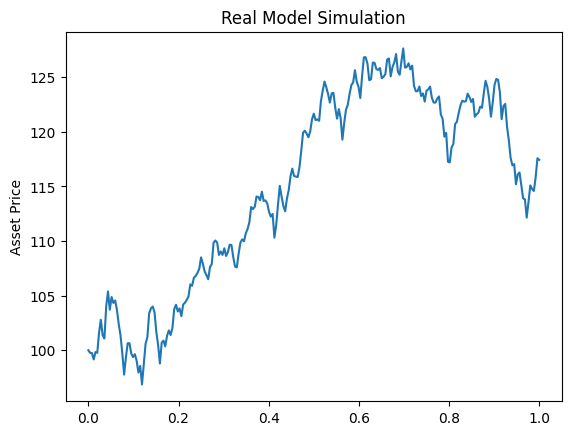

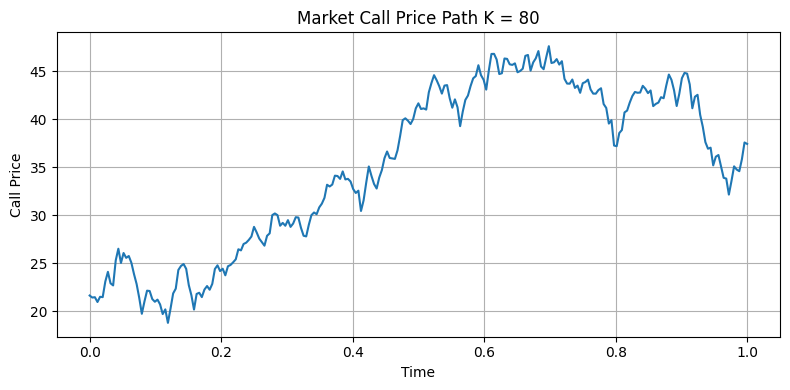

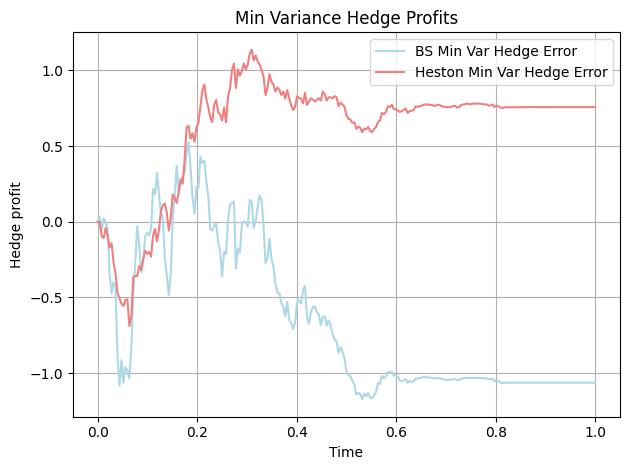

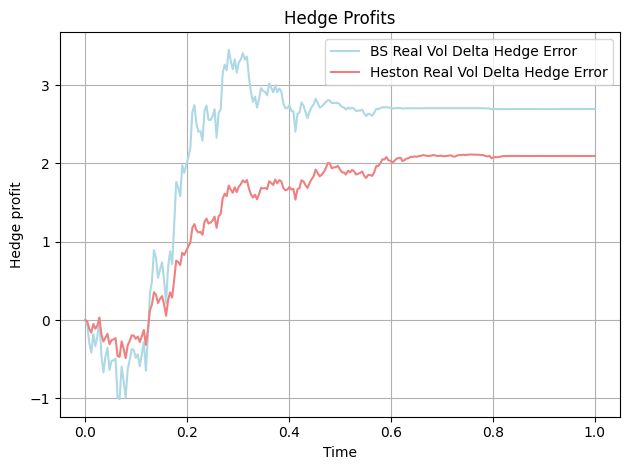

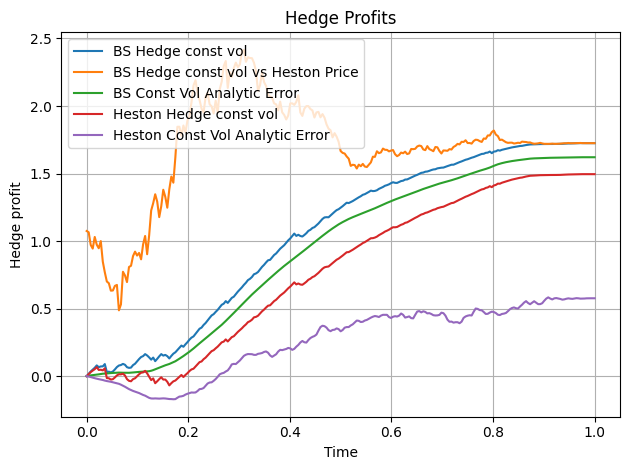

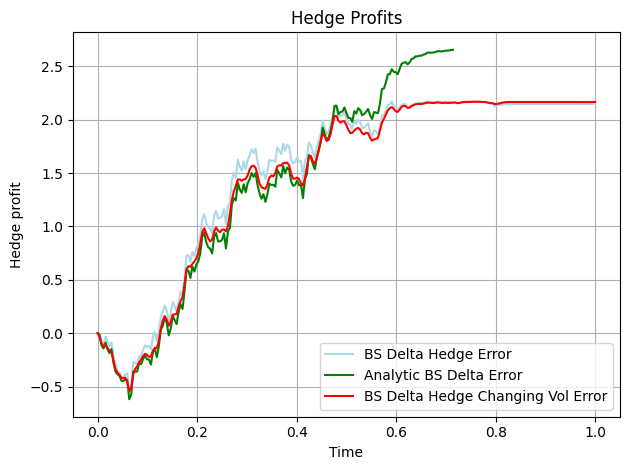

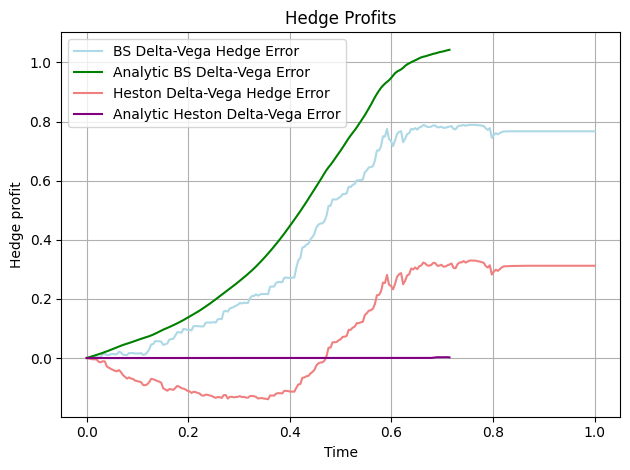

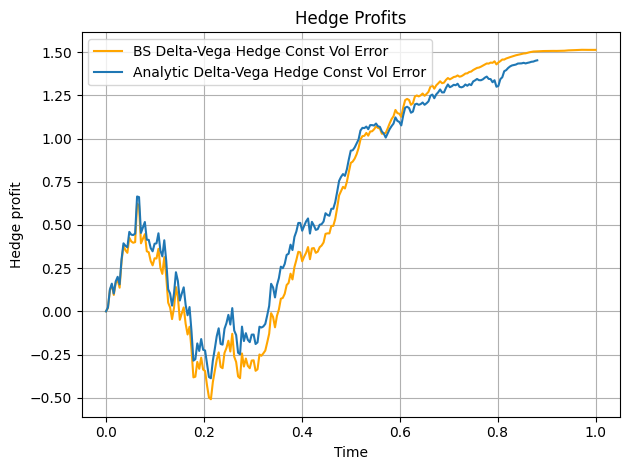

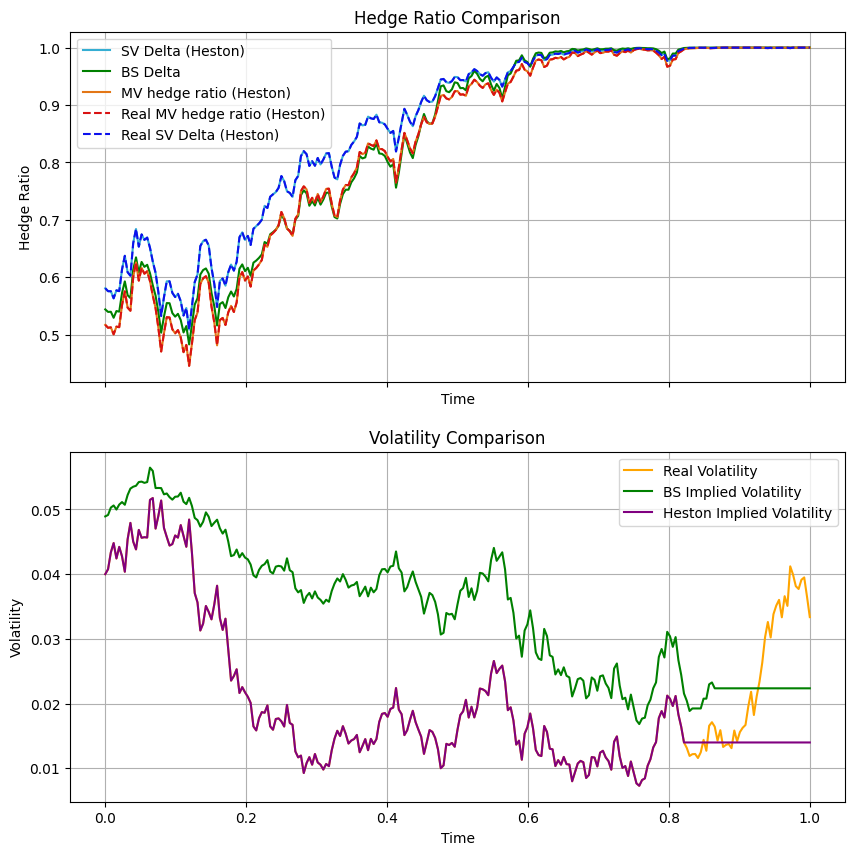

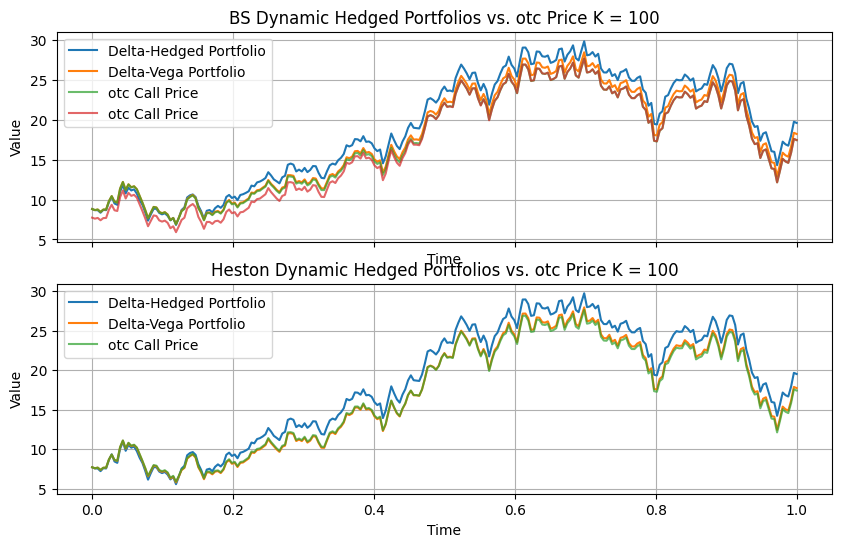

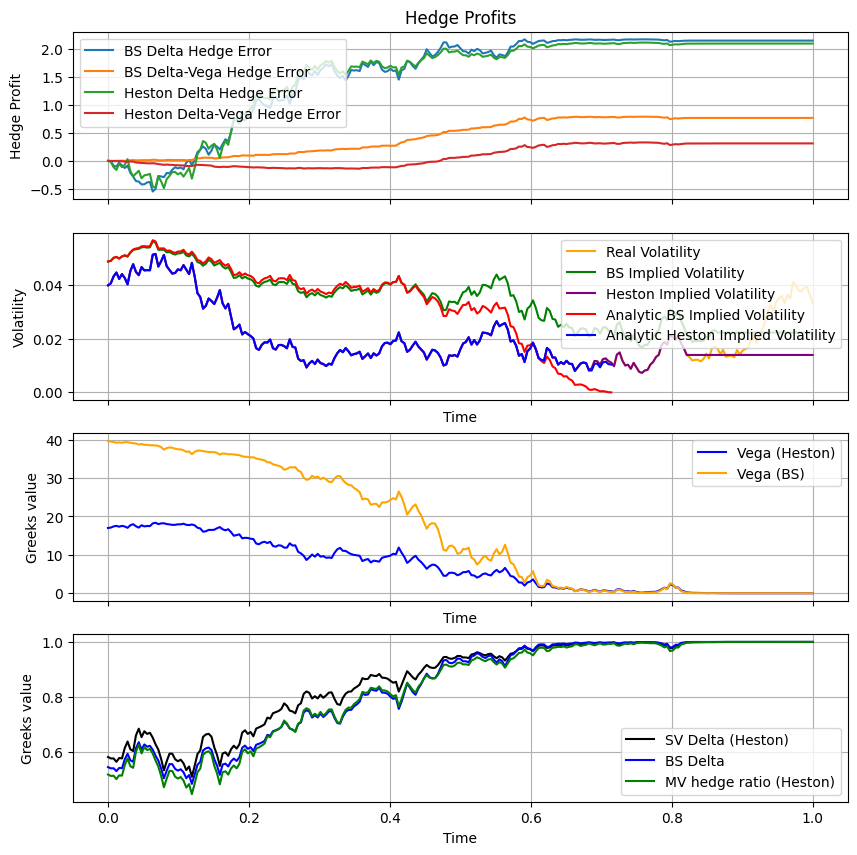

In [16]:
# --- Delta vs Delta-Vega hedge of a different strike otc call using a market ATM K = 100 call---

real_with_jumps = False
real_stein_stein = False

K_market = 80  # Market strike
K_market2 = 80 #Other market strike
K_otc  = 100  # otc strike

# 1) Heston simulation
if real_with_jumps:
    t_grid, S_path, v_path = simulate_heston_jump(S0, v0, r, kappa, theta, xi, rho, muj, sigmaj, lam, T, steps)
elif real_stein_stein:
    t_grid, S_path, v_path = simulate_stein_stein(S0, sigma0_stein, r, kappa_stein, theta_stein, xi_stein, rho_stein, T, steps)
else:
    t_grid, S_path, v_path = simulate_heston(S0, v0, r, kappa, theta, xi, rho, T, steps)

n  = len(t_grid)
dt = t_grid[1] - t_grid[0]

#For plotting/analytic calculations
otc_bs_gammas = np.zeros(n)
otc_bs_vommas = np.zeros(n)
otc_bs_vannas = np.zeros(n)
market_bs_gammas = np.zeros(n)
market_bs_vommas = np.zeros(n)
market_bs_vannas = np.zeros(n)
market_heston_gammas = np.zeros(n)
market_heston_vommas = np.zeros(n)
market_heston_vannas = np.zeros(n)
otc_heston_vannas = np.zeros(n)
otc_heston_gammas = np.zeros(n)
otc_heston_vommas = np.zeros(n)
otc_heston_vegas_vol = np.zeros(n)
otc_heston_real_deltas = np.zeros(n)
otc_heston_real_vegas = np.zeros(n)
market_heston_real_deltas = np.zeros(n)
market_heston_real_vegas = np.zeros(n)
market_heston_constvol_deltas = np.zeros(n)
market_heston_constvol_vegas = np.zeros(n)
otc_heston_constvol_vegas = np.zeros(n)
otc_heston_constvol_vommas = np.zeros(n)
otc_heston_constvol_vannas = np.zeros(n)

est_error = 0 # % estimation error
# # Incorrect paramter estimation by uniform +- % error
kappa_est = kappa + kappa * np.random.uniform(-est_error, est_error)
theta_est = theta + theta * np.random.uniform(-est_error, est_error)
xi_est = xi + xi    * np.random.uniform(-est_error, est_error)
rho_est = rho + rho   * np.random.uniform(-est_error, est_error)

# # # Incorrect paramter estimation by +- % error
# kappa_est = kappa + kappa* (-est_error + 0.0433214234)
# theta_est = theta + theta*(-est_error + 0.6124214)
# xi_est = xi + xi *(-est_error + 0.78124112443)
# rho_est = rho + rho * (-est_error + 0.712512443)


print(xi, xi_est)
print(kappa, kappa_est)
print(theta, theta_est)
print(rho, rho_est)

# Preallocate
market_prices        = np.zeros(n)
market_prices2       = np.zeros(n)
market_bs_deltas     = np.zeros(n)
market_bs_vegas      = np.zeros(n)
market_bs_constvol_deltas = np.zeros(n)
market_bs_constvol_vegas = np.zeros(n)
market_heston_deltas = np.zeros(n)
market_heston_vegas  = np.zeros(n)
otc_bs_prices        = np.zeros(n)
otc_bs_deltas        = np.zeros(n)
otc_bs_vegas         = np.zeros(n)
otc_heston_prices    = np.zeros(n)
otc_heston_deltas    = np.zeros(n)
otc_heston_vegas     = np.zeros(n)
bs_implied_vols      = np.zeros(n)
heston_implied_vols  = np.zeros(n)

otc_bs_constvol_prices = np.zeros(n)
otc_bs_constvol_deltas = np.zeros(n)
otc_bs_constvol_vegas = np.zeros(n)
otc_bs_constvol_vommas = np.zeros(n)
otc_bs_constvol_vannas = np.zeros(n)
otc_bs_constvol_gammas = np.zeros(n)
otc_bs_pathvol_prices = np.zeros(n)
otc_bs_pathvol_deltas = np.zeros(n)
otc_bs_pathvol_gammas = np.zeros(n)
otc_heston_constvol_prices = np.zeros(n)
otc_heston_constvol_deltas = np.zeros(n)
otc_heston_constvol_gammas = np.zeros(n)

otc_bs_realvol_prices = np.zeros(n)
otc_bs_realvol_deltas = np.zeros(n)
otc_heston_realvol_prices = np.zeros(n)
otc_heston_realvol_deltas = np.zeros(n)

real_vols = np.sqrt(v_path)

# Compute call prices, deltas, vegas and implied vols
for i, t in enumerate(t_grid):
    tau = T - t

    # Heston call price
    if real_stein_stein:
        market_prices[i] = stein_stein_call_price(S_path[i], real_vols[i], r,theta_stein, kappa_stein, xi_stein, rho_stein, tau, K_market)
        market_prices2[i] = stein_stein_call_price(S_path[i], real_vols[i], r,theta_stein, kappa_stein, xi_stein, rho_stein, tau, K_market2)
    else:
        market_prices[i] = heston_call_price(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)
        market_prices2[i] = heston_call_price(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market2)
        
    try:
        iv = bs_iv(market_prices[i], S_path[i], K_market, tau, r, 'c')
        iv2 = bs_iv(market_prices2[i], S_path[i], K_market2, tau, r, 'c')
        iv = (iv + iv2) / 2
        bs_implied_vols[i] = iv if iv > 0 else bs_implied_vols[i-1]
    except:
        bs_implied_vols[i] = bs_implied_vols[i-1]

    try:
        iv = (heston_implied_vol(S_path[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market, market_prices[i]))**2
        heston_implied_vols[i] = iv if iv > 1e-6 else heston_implied_vols[i-1]
    except:
        heston_implied_vols[i] = heston_implied_vols[i-1]

    # OTC call price
    otc_bs_prices[i]        = bs('c', S_path[i], K_otc, tau, r, bs_implied_vols[i])
    otc_bs_deltas[i]        = bs_call_delta(S_path[i], K_otc, tau, r, bs_implied_vols[i])
    otc_bs_vegas[i]         = bs_vega(S_path[i], K_otc, tau, r, bs_implied_vols[i])
    otc_heston_prices[i]    = heston_call_price(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
    otc_heston_deltas[i]    = heston_call_delta(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
    otc_heston_vegas[i]     = heston_call_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)

    otc_bs_constvol_prices[i] = bs('c', S_path[i], K_otc, tau, r, bs_implied_vols[0])
    otc_bs_constvol_deltas[i] = bs_call_delta(S_path[i], K_otc, tau, r, bs_implied_vols[0])
    otc_bs_constvol_gammas[i] = bs_call_gamma(S_path[i], K_otc, tau, r, bs_implied_vols[0])
    otc_bs_constvol_vegas[i] = bs_vega(S_path[i], K_otc, tau, r, bs_implied_vols[0])
    otc_bs_constvol_vommas[i] = bs_vomma(S_path[i], K_otc, tau, r, bs_implied_vols[0])
    otc_bs_constvol_vannas[i] = bs_call_vanna(S_path[i], K_otc, tau, r, bs_implied_vols[0])
    otc_heston_constvol_prices[i] = heston_call_price(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
    otc_heston_constvol_deltas[i] = heston_call_delta(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
    otc_heston_constvol_gammas[i] = heston_call_gamma(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
    otc_heston_constvol_vegas[i] = heston_call_vega(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
    otc_heston_constvol_vannas[i] = heston_call_vanna(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)

    market_bs_deltas[i]     = bs_call_delta(S_path[i], K_market, tau, r, bs_implied_vols[i])
    market_bs_constvol_deltas[i] = bs_call_delta(S_path[i], K_market, tau, r, bs_implied_vols[0])
    market_bs_vegas[i]      = bs_vega(S_path[i], K_market, tau, r, bs_implied_vols[i])
    market_bs_constvol_vegas[i] = bs_vega(S_path[i], K_market, tau, r, bs_implied_vols[0])
    market_heston_deltas[i] = heston_call_delta(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    market_heston_vegas[i]  = heston_call_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    market_heston_gammas[i] = heston_call_gamma(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    market_heston_vommas[i] = heston_call_vomma(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    market_heston_vannas[i] = heston_call_vanna(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    market_heston_constvol_deltas[i] = heston_call_delta(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    market_heston_constvol_vegas[i] = heston_call_vega(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    # market_heston_constvol_gammas[i] = heston_call_gamma(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    # market_heston_constvol_vommas[i] = heston_call_vomma(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    # market_heston_constvol_vannas[i] = heston_call_vanna(S_path[i], heston_implied_vols[0], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    otc_heston_vannas[i] = heston_call_vanna(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)

    otc_bs_pathvol_gammas[i] = bs_call_gamma(S_path[i], K_otc, tau, r, bs_implied_vols[i])

    #Using real vols
    otc_bs_realvol_prices[i] = bs('c', S_path[i], K_otc, tau, r, real_vols[i])
    otc_bs_realvol_deltas[i] = bs_call_delta(S_path[i], K_otc, tau, r, real_vols[i])
    otc_heston_realvol_prices[i] = heston_call_price(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc)
    otc_heston_realvol_deltas[i] = heston_call_delta(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc)

    # Just for plotting/analytic calculations
    otc_bs_gammas[i] = bs_call_gamma(S_path[i], K_otc, tau, r, bs_implied_vols[i])
    otc_bs_vommas[i] = bs_vomma(S_path[i], K_otc, tau, r, bs_implied_vols[i])
    otc_bs_vannas[i] = bs_call_vanna(S_path[i], K_otc, tau, r, bs_implied_vols[i])
    market_bs_gammas[i] = bs_call_gamma(S_path[i], K_market, tau, r, bs_implied_vols[i])
    market_bs_vommas[i] = bs_vomma(S_path[i], K_market, tau, r, bs_implied_vols[i])
    market_bs_vannas[i] = bs_call_vanna(S_path[i], K_market, tau, r, bs_implied_vols[i])
    otc_heston_gammas[i] = heston_call_gamma(S_path[i], heston_implied_vols[i], r, kappa, theta, xi, rho, tau, K_otc)
    otc_heston_real_deltas[i] = heston_call_delta(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc)
    otc_heston_real_vegas[i] = heston_call_vega(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc)
    market_heston_real_deltas[i] = heston_call_delta(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)
    market_heston_real_vegas[i] = heston_call_vega(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)
#    otc_heston_vommas[i] = heston_call_vomma(S_path[i], heston_implied_vols[i], r, kappa, theta, xi, rho, tau, K_otc)

heston_implied_vols = np.sqrt(heston_implied_vols)

bs_implied_const_vols = bs_implied_vols[0] * np.ones_like(bs_implied_vols)
heston_implied_const_vols = heston_implied_vols[0] * np.ones_like(heston_implied_vols)

#Adjust form via Ito to find a(Y) for given form in the paper
a_Y = (((4*kappa*theta - xi**2) / (8*real_vols)) - ((kappa*real_vols) / 2))
b_Y = xi/2

a_I = (((4*kappa_est*theta_est - xi_est**2) / (8*heston_implied_vols)) - ((kappa_est*heston_implied_vols) / 2))
b_I = xi_est/2

a_I_constvol = (((4*kappa_est*theta_est - xi_est**2) / (8*heston_implied_const_vols)) - ((kappa_est*heston_implied_const_vols) / 2))
b_I_constvol = xi_est/2



# --- Delta const-vol BS hedge ---
portfolio_bs_delta_const_vol = delta_hedge(S_path, otc_bs_constvol_deltas, otc_bs_constvol_prices[0], r, t_grid)

# --- Delta const-vol Heston hedge ---
portfolio_heston_delta_const_vol = delta_hedge(S_path, otc_heston_constvol_deltas, otc_heston_constvol_prices[0], r, t_grid)

# --- Delta-only heston hedge ---
portfolio_heston_delta = delta_hedge(S_path, otc_heston_deltas, otc_heston_prices[0], r, t_grid)

# --- Delta‐only bs hedge ---
portfolio_bs_delta = delta_hedge(S_path, otc_bs_deltas, otc_bs_prices[0], r, t_grid)

# --- Delta‐Vega bs hedge with market calls---
portfolio_bs_dv = delta_vega_hedge(S_path, otc_bs_deltas, otc_bs_vegas, market_bs_deltas, market_prices, market_bs_vegas, otc_bs_prices[0], r, t_grid)

# --- Delta‐Vega heston hedge with market calls---
portfolio_heston_dv = delta_vega_hedge(S_path, otc_heston_deltas, otc_heston_vegas, market_heston_deltas, market_prices, market_heston_vegas, otc_heston_prices[0], r, t_grid)

# --- Delta‐Vega bs hedge with market calls and constant vol BS ---
portfolio_bs_constvol_dv = delta_vega_hedge(S_path, otc_bs_constvol_deltas, otc_bs_constvol_vegas, market_bs_constvol_deltas, market_prices, market_bs_constvol_vegas, otc_bs_constvol_prices[0], r, t_grid)

#Real vols delta-hedge
portfolio_bs_realvol_delta = delta_hedge(S_path, otc_bs_realvol_deltas, otc_bs_realvol_prices[0], r, t_grid)
portfolio_heston_realvol_delta = delta_hedge(S_path, otc_heston_realvol_deltas, otc_heston_realvol_prices[0], r, t_grid)

#Min variance hedge BS
portfolio_bs_min_var = min_variance_hedge(S_path, otc_bs_deltas, otc_bs_vegas, otc_bs_prices[0], r, rho_est, b_I, real_vols, t_grid)

#Min variance hedge Heston
portfolio_heston_min_var = min_variance_hedge(S_path, otc_heston_deltas, otc_heston_vegas, otc_heston_prices[0], r, rho_est, b_I, heston_implied_vols, t_grid)


# ---Remove numerical errors - make elements less than eps equal to zero ---
eps = 1e-6
market_bs_vegas = np.where(market_bs_vegas < eps, 0, market_bs_vegas)
market_bs_constvol_vegas = np.where(market_bs_constvol_vegas < eps, 0, market_bs_constvol_vegas)
market_heston_vegas = np.where(market_heston_vegas < eps, 0, market_heston_vegas)
market_heston_constvol_vegas = np.where(market_heston_constvol_vegas < eps, 0, market_heston_constvol_vegas)


residual_path = 0.5 * (bs_implied_vols**2 - real_vols**2) * (S_path**2) * (otc_bs_pathvol_gammas)
residual_path_integral = np.concatenate(([0], cumulative_trapezoid(residual_path, t_grid)))

# residual_const = 0.5 * (bs_implied_const_vols**2 - real_vols**2) * (S_path**2) * (otc_bs_constvol_gammas)
# residual_const_integral = np.concatenate(([0], cumulative_trapezoid(residual_const, t_grid)))



# --- Analytic bs errors ---
analytic_bs_implied_vol = implied_vol_dynamics(S_path, real_vols, bs_implied_vols, market_bs_deltas, market_heston_real_deltas, market_bs_vegas, market_heston_real_vegas, market_bs_gammas, market_bs_vommas, market_bs_vannas, a_Y, b_Y, rho, 0, 0, 0, t_grid)

analytic_bs_delta_error = delta_hedge_error_implied_vol(S_path, real_vols, bs_implied_vols, market_bs_deltas, market_heston_real_deltas, market_bs_vegas, market_heston_real_vegas, otc_bs_vegas, market_bs_gammas, otc_bs_gammas, market_bs_vommas, otc_bs_vommas, market_bs_vannas, otc_bs_vannas, a_Y, b_Y, rho, 0, 0, 0, t_grid)

analytic_bs_dv_error = delta_vega_hedge_error_implied_vol(S_path, real_vols, bs_implied_vols, market_bs_deltas, market_heston_real_deltas, market_bs_vegas, market_heston_real_vegas, otc_bs_vegas, market_bs_gammas, otc_bs_gammas, market_bs_vommas, otc_bs_vommas, market_bs_vannas, otc_bs_vannas, a_Y, b_Y, rho, 0, 0, 0, t_grid)

analytic_bs_contvol_delta_error = delta_hedge_error_local_vol(S_path, real_vols, bs_implied_const_vols, otc_bs_constvol_vegas, otc_bs_constvol_gammas, otc_bs_constvol_vommas, otc_bs_constvol_vannas, 0, 0, 0, t_grid)

analytic_bs_constvol_dv_error = delta_vega_hedge_error_local_vol(S_path, real_vols, bs_implied_const_vols, market_bs_constvol_deltas, market_heston_real_deltas, market_bs_constvol_vegas, market_heston_real_vegas, otc_bs_constvol_vegas, otc_bs_constvol_gammas, otc_bs_constvol_vommas, otc_bs_constvol_vannas, a_Y, b_Y, 0, 0, 0, t_grid)

partial_I_t = np.gradient(bs_implied_vols, dt)

analytic_bs_delta_changing_vol = delta_hedge_changing_vol(S_path, real_vols, bs_implied_vols, otc_bs_vegas, otc_bs_gammas, otc_bs_vommas, otc_bs_vannas, 0, 0, 0, partial_I_t, t_grid)

# --- Analytic heston error ---
analytic_heston_implied_vol = implied_vol_dynamics(S_path, real_vols, heston_implied_vols, market_heston_deltas, market_heston_real_deltas, market_heston_vegas, market_heston_real_vegas, market_heston_gammas, market_heston_vommas, market_heston_vannas, a_Y, b_Y, rho, a_I, b_I, rho_est, t_grid)

analytic_heston_delta_error = delta_hedge_error_implied_vol(S_path, real_vols, heston_implied_vols, market_heston_deltas, market_heston_real_deltas, market_heston_vegas, market_heston_real_vegas, otc_heston_vegas, market_heston_gammas, otc_heston_gammas, market_heston_vommas, otc_heston_vommas, market_heston_vannas, otc_heston_vannas, a_Y, b_Y, rho, a_I, b_I, rho_est, t_grid)

analytic_heston_dv_error = delta_vega_hedge_error_implied_vol(S_path, real_vols, heston_implied_vols, market_heston_deltas, market_heston_real_deltas,  market_heston_vegas, market_heston_real_vegas, otc_heston_vegas, market_heston_gammas, otc_heston_gammas, market_heston_vommas, otc_heston_vommas, market_heston_vannas, otc_heston_vannas, a_Y, b_Y, rho, a_I, b_I, rho_est, t_grid)

analytic_heston_constvol_delta_error = delta_hedge_error_local_vol(S_path, real_vols, heston_implied_const_vols, otc_heston_constvol_vegas, otc_heston_constvol_gammas, otc_heston_constvol_vommas, otc_heston_constvol_vannas, a_I_constvol, b_I_constvol, rho_est, t_grid)

analytic_heston_constvol_dv_error = delta_vega_hedge_error_local_vol(S_path, real_vols, heston_implied_const_vols, market_heston_constvol_deltas, market_heston_real_deltas, market_heston_constvol_vegas, market_heston_real_vegas, otc_heston_constvol_vegas, otc_heston_constvol_gammas, otc_heston_constvol_vommas, otc_heston_constvol_vannas, a_Y, b_Y, a_I_constvol, b_I_constvol, rho_est, t_grid)

for i in range(n):
    if abs(analytic_bs_delta_error[i]) > 10:
        analytic_bs_delta_error[i] = analytic_bs_delta_error[i-1]
    if abs(analytic_bs_dv_error[i]) > 10:
        analytic_bs_dv_error[i] = analytic_bs_dv_error[i-1]
    if abs(analytic_bs_contvol_delta_error[i]) > 10:
        analytic_bs_contvol_delta_error[i] = analytic_bs_contvol_delta_error[i-1]
    if abs(analytic_bs_constvol_dv_error[i]) > 10:
        analytic_bs_constvol_dv_error[i] = analytic_bs_constvol_dv_error[i-1]
    if abs(analytic_heston_delta_error[i]) > 10:
        analytic_heston_delta_error[i] = analytic_heston_delta_error[i-1]
    if abs(analytic_heston_dv_error[i]) > 3:
        analytic_heston_dv_error[i] = analytic_heston_dv_error[i-1]
    if abs(analytic_heston_constvol_delta_error[i]) > 5:
        analytic_heston_constvol_delta_error[i] = analytic_heston_constvol_delta_error[i-1]
    if abs(analytic_heston_constvol_dv_error[i]) > 5:
        analytic_heston_constvol_dv_error[i] = analytic_heston_constvol_dv_error[i-1]
    if abs(analytic_bs_implied_vol[i]) > 1 or analytic_bs_implied_vol[i] < 0:
        analytic_bs_implied_vol[i] = analytic_bs_implied_vol[i-1]
    if abs(analytic_heston_implied_vol[i]) > 1 or analytic_heston_implied_vol[i] < 0:
        analytic_heston_implied_vol[i] = analytic_heston_implied_vol[i-1]

# Asset price subplot
plt.plot(t_grid, S_path)
plt.ylabel("Asset Price")
plt.title("Real Model Simulation")

# Plot the market call price path
plt.figure(figsize=(8, 4))
plt.plot(t_grid, market_prices, label='Market Call Price')
plt.title(f"Market Call Price Path K = {K_market}")
plt.xlabel("Time")
plt.ylabel("Call Price")
plt.grid(True)
plt.tight_layout()
plt.show()

#Min Var hedges
plt.plot(t_grid, portfolio_bs_min_var - otc_bs_prices, label='BS Min Var Hedge Error', color = 'lightblue')
plt.plot(t_grid, portfolio_heston_min_var - otc_heston_prices, label='Heston Min Var Hedge Error', color = 'lightcoral')
plt.title("Min Variance Hedge Profits")
plt.xlabel("Time")
plt.ylabel("Hedge profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Realvols delta-hedge:
plt.plot(t_grid, portfolio_bs_realvol_delta - otc_bs_realvol_prices, label='BS Real Vol Delta Hedge Error', color = 'lightblue')
plt.plot(t_grid, portfolio_heston_realvol_delta - otc_heston_realvol_prices, label='Heston Real Vol Delta Hedge Error', color = 'lightcoral')
plt.title("Hedge Profits")
plt.xlabel("Time")
plt.ylabel("Hedge profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(t_grid, portfolio_bs_delta_const_vol - otc_bs_constvol_prices, label = 'BS Hedge const vol')
plt.plot(t_grid, portfolio_bs_delta_const_vol - otc_heston_prices, label = 'BS Hedge const vol vs Heston Price')
plt.plot(t_grid,  analytic_bs_contvol_delta_error, label = 'BS Const Vol Analytic Error')
plt.plot(t_grid, portfolio_heston_delta_const_vol - otc_heston_constvol_prices, label = 'Heston Hedge const vol')
plt.plot(t_grid, analytic_heston_constvol_delta_error, label = 'Heston Const Vol Analytic Error')
plt.title("Hedge Profits")
plt.xlabel("Time")
plt.ylabel("Hedge profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(t_grid, portfolio_bs_delta - otc_bs_prices, label='BS Delta Hedge Error', color = 'lightblue')
plt.plot(t_grid, analytic_bs_delta_error, label='Analytic BS Delta Error', color = 'green')
#plt.plot(t_grid, portfolio_heston_delta - otc_heston_prices, label='Heston Delta Hedge Error', color = 'lightcoral')
#plt.plot(t_grid, analytic_heston_delta_error, label='Analytic Heston Delta Error', color = 'purple')
#plt.plot(t_grid, residual_path_integral, label = 'Path Vol Analytic Error (Wrong One)', color = 'orange')
plt.plot(t_grid, analytic_bs_delta_changing_vol, label = 'BS Delta Hedge Changing Vol Error', color = 'red')
plt.title("Hedge Profits")
plt.xlabel("Time")
plt.ylabel("Hedge profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(t_grid, portfolio_bs_dv - otc_bs_prices, label='BS Delta-Vega Hedge Error', color = 'lightblue')
plt.plot(t_grid, analytic_bs_dv_error, label='Analytic BS Delta-Vega Error', color = 'green')
plt.plot(t_grid, portfolio_heston_dv - otc_heston_prices, label='Heston Delta-Vega Hedge Error', color = 'lightcoral')
plt.plot(t_grid, analytic_heston_dv_error, label='Analytic Heston Delta-Vega Error', color = 'purple')
plt.title("Hedge Profits")
plt.xlabel("Time")
plt.ylabel("Hedge profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.plot(t_grid, portfolio_bs_constvol_dv - otc_bs_constvol_prices, label='BS Delta-Vega Hedge Const Vol Error', color = 'orange')
plt.plot(t_grid, analytic_bs_constvol_dv_error, label = 'Analytic Delta-Vega Hedge Const Vol Error')
#plt.plot(t_grid, portfolio_heston_dv_const_vol - otc_heston_constvol_prices, label='Heston Delta-Vega Hedge Const Vol Error', color = 'lightcoral')
#plt.plot(t_grid, analytic_heston_constvol_dv_error, label = 'Analytic Heston Delta-Vega Hedge Const Vol Error', color = 'purple')
plt.title("Hedge Profits")
plt.xlabel("Time")
plt.ylabel("Hedge profit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)


ax1.plot(t_grid, otc_heston_deltas, label='SV Delta (Heston)', linestyle = '-', color="#35aed3")
ax1.plot(t_grid, otc_bs_deltas, label='BS Delta', color='green')
ax1.plot(t_grid, otc_heston_deltas + ((rho_est * b_I)/(S_path * heston_implied_vols))* otc_heston_vegas, label='MV hedge ratio (Heston)', linestyle = '-', color="#E37616")
ax1.plot(t_grid, otc_heston_real_deltas + ((rho * b_Y)/(S_path * real_vols))* otc_heston_real_vegas, label='Real MV hedge ratio (Heston)', linestyle = '--', color="#D91212")
ax1.plot(t_grid, otc_heston_real_deltas, label='Real SV Delta (Heston)',linestyle = '--', color="#0c10ed")
#ax4.plot(t_grid, otc_heston_real_deltas + ((rho * b_Y)/(S_path * real_vols))* otc_heston_real_vegas, label='Real Min Var hedge amount (Heston)', color='orange')
#ax4.plot(t_grid, otc_heston_gammas, label='Gamma (Heston)', color='red')
#ax4.plot(t_grid, otc_bs_gammas, label='Gamma (BS)', color='purple'),
ax1.set_title("Hedge Ratio Comparison")
ax1.set_xlabel("Time")
ax1.set_ylabel("Hedge Ratio")
ax1.legend()
ax1.grid(True)

ax2.plot(t_grid, real_vols**2, label='Real Volatility', color='orange')
ax2.plot(t_grid, bs_implied_vols**2, label='BS Implied Volatility', color='green')
ax2.plot(t_grid, heston_implied_vols**2, label = 'Heston Implied Volatility', color = 'purple')
#plt.plot(t_grid, analytic_bs_implied_vol**2, label = 'Analytic BS Implied Volatility', color = 'red')
#plt.plot(t_grid, analytic_heston_implied_vol**2, label = 'Analytic Heston Implied Volatility', color = 'blue')
ax2.set_title("Volatility Comparison")
ax2.set_xlabel("Time")
ax2.set_ylabel("Volatility")
ax2.legend()
ax2.grid(True)

# Plot delta vs delta-vega hedged portfolios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_grid, portfolio_bs_delta, label='Delta-Hedged Portfolio')
ax1.plot(t_grid, portfolio_bs_dv, label='Delta-Vega Portfolio')
ax1.plot(t_grid, otc_bs_prices, label='otc Call Price', alpha=0.7)
ax1.plot(t_grid, otc_heston_prices, label='otc Call Price', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title(f'BS Dynamic Hedged Portfolios vs. otc Price K = {K_otc}')
ax1.legend()
ax1.grid(True)

ax2.plot(t_grid, portfolio_heston_delta, label='Delta-Hedged Portfolio')
ax2.plot(t_grid, portfolio_heston_dv, label='Delta-Vega Portfolio')
ax2.plot(t_grid, otc_heston_prices, label='otc Call Price', alpha=0.7)
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title(f'Heston Dynamic Hedged Portfolios vs. otc Price K = {K_otc}')
ax2.legend()
ax2.grid(True)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

ax1.plot(t_grid, portfolio_bs_delta - otc_bs_prices, label='BS Delta Hedge Error')
ax1.plot(t_grid, portfolio_bs_dv - otc_bs_prices, label='BS Delta-Vega Hedge Error')
ax1.plot(t_grid, portfolio_heston_delta - otc_heston_prices, label='Heston Delta Hedge Error')
ax1.plot(t_grid, portfolio_heston_dv - otc_heston_prices, label='Heston Delta-Vega Hedge Error')
ax2.set_xlabel("Time")
ax1.set_ylabel("Hedge Profit")
ax1.set_title("Hedge Profits")
ax1.legend()
ax1.grid(True)

ax2.plot(t_grid, real_vols**2, label='Real Volatility', color='orange')
ax2.plot(t_grid, bs_implied_vols**2, label='BS Implied Volatility', color='green')
ax2.plot(t_grid, heston_implied_vols**2, label = 'Heston Implied Volatility', color = 'purple')
ax2.plot(t_grid, analytic_bs_implied_vol**2, label = 'Analytic BS Implied Volatility', color = 'red')
ax2.plot(t_grid, analytic_heston_implied_vol**2, label = 'Analytic Heston Implied Volatility', color = 'blue')
ax2.set_xlabel("Time")
ax2.set_ylabel("Volatility")
ax2.legend()
ax2.grid(True)

ax3.plot(t_grid, otc_heston_vegas, label='Vega (Heston)', color='blue')
ax3.plot(t_grid, otc_bs_vegas, label='Vega (BS)', color='orange')
#ax3.plot(t_grid, otc_heston_vegas_vol, label='Vega_vol (Heston)', color='purple')
#ax3.plot(t_grid, otc_heston_vommas, label='Vomma (Heston)', color='purple')
#ax3.plot(t_grid, otc_bs_vommas, label='Vomma (BS)', color='red')
ax3.set_xlabel("Time")
ax3.set_ylabel("Greeks value")
ax3.legend()
ax3.grid(True)

ax4.plot(t_grid, otc_heston_deltas, label='SV Delta (Heston)', color='black')
ax4.plot(t_grid, otc_bs_deltas, label='BS Delta', color='blue')
ax4.plot(t_grid, otc_heston_deltas + ((rho_est * b_I)/(S_path * heston_implied_vols))* otc_heston_vegas, label='MV hedge ratio (Heston)', color='green')
#ax4.plot(t_grid, otc_heston_real_deltas + ((rho * b_Y)/(S_path * real_vols))* otc_heston_real_vegas, label='Real Min Var hedge amount (Heston)', color='orange')
#ax4.plot(t_grid, otc_heston_gammas, label='Gamma (Heston)', color='red')
#ax4.plot(t_grid, otc_bs_gammas, label='Gamma (BS)', color='purple')
ax4.set_xlabel("Time")
ax4.set_ylabel("Greeks value")
ax4.legend()
ax4.grid(True)

Average Heston minus BS initial price: -1.1054
Average BS IV Error Integral:    0.0000
Average heston IV Error Integral:    0.0000
Average BS Delta-Only P/L:        0.0000
Variance BS Delta-Only P/L:        0.0000
Average BS Delta-Vega-Hedge P/L:  1.2772
Variance BS Delta-Vega-Hedge P/L:  0.6581
Average Heston Delta-Only P/L: -0.0288
Variance Heston Delta-Only P/L: 2.8664
Average Heston Delta-Vega P/L: 0.0888
Variance Heston Delta-Vega P/L: 0.5545
Average BS Delta Const Vol P/L: 0.0000
Variance BS Delta Const Vol P/L: 0.0000
Average Heston Min Var Delta P/L: -0.0201
Variance Heston Min Var Delta P/L: 1.9827
(np.float64(1.9637586410384371), np.float64(2.002674823214514))
(np.float64(0.0), np.float64(0.0))
(np.float64(2.842721149600062), np.float64(2.890208618363051))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.0), np.float64(0.0))
(np.float64(0.6527091716418987), np.float64(0.6634370620994835))
(np.float64(0.5475167526327731), np.float64(0.561604782562633))


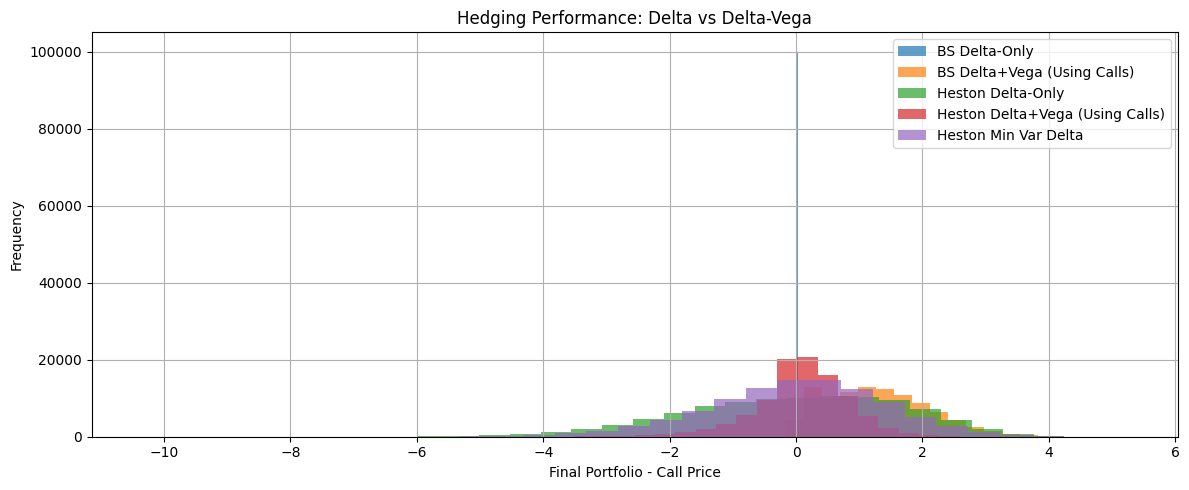

In [34]:
sims = 100000

real_with_jumps = False
real_stein_stein = False

est_error = 0.4

# Storage
bs_hedging_perf_delta_only = np.zeros(sims)
bs_hedging_perf_delta_vega = np.zeros(sims)
heston_hedging_perf_delta_only = np.zeros(sims)
heston_hedging_perf_delta_vega = np.zeros(sims)
bs_constvol_hedging_perf_delta_only = np.zeros(sims)
heston_hedging_perf_minvar_delta_only = np.zeros(sims)
bs_hedging_perf_minvar_delta_only = np.zeros(sims)

# implied vol error integral
bs_iv_error_integrals     = np.zeros(sims)
heston_iv_error_integrals = np.zeros(sims)

K_market = 80  # Market strike
K_otc  = 100  # otc strike


# K_market1 = 95
# K_market2 = 105

heston_minus_bs_initial_price = 0

for N in range(sims):
    # 1) Heston simulation
    if real_with_jumps:
        t_grid, S_path, v_path = simulate_heston_jump(S0, v0, r, kappa, theta, xi, rho, muj, sigmaj, lam, T, steps)
    elif real_stein_stein:
        t_grid, S_path, v_path = simulate_stein_stein(S0, sigma0_stein, r, kappa_stein, theta_stein, xi_stein, rho_stein, T, steps)
    else:
        t_grid, S_path, v_path = simulate_heston(S0, v0, r, kappa, theta, xi, rho, T, steps)
    n  = len(t_grid)
    dt = t_grid[1] - t_grid[0]
        
    # Incorrect paramter estimation by uniform -err to err%
    kappa_est = kappa + kappa * np.random.uniform(-est_error, est_error)
    theta_est = theta + theta * np.random.uniform(-est_error, est_error)
    xi_est = xi + xi * np.random.uniform(-est_error, est_error)
    rho_est = rho + rho * np.random.uniform(-est_error, est_error)

    # Preallocate
    market_prices        = np.zeros(n)
    market_bs_deltas     = np.zeros(n)
    market_bs_vegas      = np.zeros(n)
    market_heston_deltas = np.zeros(n)
    market_heston_vegas  = np.zeros(n)
    otc_bs_prices        = np.zeros(n)
    otc_bs_deltas        = np.zeros(n)
    otc_bs_vegas         = np.zeros(n)
    otc_heston_prices    = np.zeros(n)
    otc_heston_deltas    = np.zeros(n)
    otc_heston_vegas     = np.zeros(n)
    bs_implied_vols      = np.zeros(n)
    heston_implied_vols  = np.zeros(n)

#    otc_bs_constvol_prices = np.zeros(n)
#    otc_bs_constvol_deltas = np.zeros(n)

    real_vols = np.sqrt(v_path)

    # Compute call prices, deltas, vegas and implied vols
    for i, t in enumerate(t_grid):
        tau = T - t

        # Heston call price
        if real_stein_stein:
            market_prices[i] = stein_stein_call_price(S_path[i], real_vols[i], r,theta_stein, kappa_stein, xi_stein, rho_stein, tau, K_market)
        else:
            market_prices[i] = heston_call_price(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)
        
        try:
            iv = bs_iv(market_prices[i], S_path[i], K_market, tau, r, 'c')
#            iv2 = bs_iv(market_prices[i], S_path[i], K_market, tau, r, 'c')
#            iv = (iv + iv2) / 2
            bs_implied_vols[i] = iv if iv > 0 else bs_implied_vols[i-1]
        except:
            bs_implied_vols[i] = bs_implied_vols[i-1]

        try:
            iv = (heston_implied_vol(S_path[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market, market_prices[i]))**2
            heston_implied_vols[i] = iv if iv > 1e-6 else heston_implied_vols[i-1]
        except:
            heston_implied_vols[i] = heston_implied_vols[i-1]

        # OTC call price
        otc_bs_prices[i]    = bs('c', S_path[i], K_otc, tau, r, bs_implied_vols[i])
        otc_bs_deltas[i]     = bs_call_delta(S_path[i], K_otc, tau, r, bs_implied_vols[i])
        otc_bs_vegas[i]      = bs_vega(S_path[i], K_otc, tau, r, bs_implied_vols[i])
        otc_heston_prices[i] = heston_call_price(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
        otc_heston_deltas[i] = heston_call_delta(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
        otc_heston_vegas[i]  = heston_call_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc)
        market_bs_deltas[i] = bs_call_delta(S_path[i], K_market, tau, r, bs_implied_vols[i])
        market_bs_vegas[i]  = bs_vega(S_path[i], K_market, tau, r, bs_implied_vols[i])
        market_heston_deltas[i] = heston_call_delta(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
        market_heston_vegas[i]  = heston_call_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)

#        otc_bs_constvol_prices[i] = bs('c', S_path[i], K_otc, tau, r, bs_implied_vols[0])
#        otc_bs_constvol_deltas[i] = bs_call_delta(S_path[i], K_otc, tau, r, bs_implied_vols[0])
    
    # bs_iv_error_integrals[N] = np.trapezoid(bs_implied_vols - real_vols, t_grid)
    # heston_iv_error_integrals[N] = np.trapezoid(np.sqrt(heston_implied_vols) - real_vols, t_grid)

    # --- Delta‐only bs hedge ---
#    portfolio_bs_delta = delta_hedge(S_path, otc_bs_deltas, otc_bs_prices[0], r, t_grid)
#    bs_hedging_perf_delta_only[N] = portfolio_bs_delta[-1] - otc_bs_prices[-1]

    # --- Delta‐only heston hedge ---
    portfolio_heston_delta = delta_hedge(S_path, otc_heston_deltas, otc_heston_prices[0], r, t_grid)
    heston_hedging_perf_delta_only[N] = portfolio_heston_delta[-1] - otc_heston_prices[-1]

    # --- Delta const-vol bs hedge ---
#    portfolio_bs_constvol_delta = delta_hedge(S_path, otc_bs_constvol_deltas, otc_bs_constvol_prices[0], r, t_grid)
#    bs_constvol_hedging_perf_delta_only[N] = portfolio_bs_constvol_delta[-1] - otc_bs_constvol_prices[-1]

    # --- Delta‐Vega bs hedge with market calls---
    portfolio_bs_dv = delta_vega_hedge(S_path, otc_bs_deltas, otc_bs_vegas, market_bs_deltas, market_prices, market_bs_vegas, otc_bs_prices[0], r, t_grid)
    bs_hedging_perf_delta_vega[N] = portfolio_bs_dv[-1] - otc_bs_prices[-1]

    # --- Delta‐Vega heston hedge with market calls---
    portfolio_heston_dv = delta_vega_hedge(S_path, otc_heston_deltas, otc_heston_vegas, market_heston_deltas, market_prices, market_heston_vegas, otc_heston_prices[0], r, t_grid)
    heston_hedging_perf_delta_vega[N] = portfolio_heston_dv[-1] - otc_heston_prices[-1]

    # --- Heston minimum variance delta-hedge ---
    b_I = xi_est/2
    portfolio_heston_minvar_delta = min_variance_hedge(S_path, otc_heston_deltas, otc_heston_vegas, otc_heston_prices[0], r, rho_est, b_I, np.sqrt(heston_implied_vols), t_grid)
    heston_hedging_perf_minvar_delta_only[N] = portfolio_heston_minvar_delta[-1] - otc_heston_prices[-1]

    # # --- Delta minimum variance delta-hedge ---
    # portfolio_bs_min_var = min_variance_hedge(S_path, otc_bs_deltas, otc_heston_vegas, otc_bs_prices[0], r, rho_est, b_I, np.sqrt(heston_implied_vols), t_grid)
    # bs_hedging_perf_minvar_delta_only[N] = portfolio_bs_min_var[-1] - otc_bs_prices[-1]

    heston_minus_bs_initial_price += otc_heston_prices[0] - otc_bs_prices[0]


# --- Results ---
print(f"Average Heston minus BS initial price: {(heston_minus_bs_initial_price/sims):.4f}")

print(f"Average BS IV Error Integral:    {bs_iv_error_integrals.mean():.4f}")
print(f"Average heston IV Error Integral:    {heston_iv_error_integrals.mean():.4f}")
print(f"Average BS Delta-Only P/L:        {bs_hedging_perf_delta_only.mean():.4f}")
print(f"Variance BS Delta-Only P/L:        {bs_hedging_perf_delta_only.var():.4f}")
print(f"Average BS Delta-Vega-Hedge P/L:  {bs_hedging_perf_delta_vega.mean():.4f}")
print(f"Variance BS Delta-Vega-Hedge P/L:  {bs_hedging_perf_delta_vega.var():.4f}")
print(f"Average Heston Delta-Only P/L: {heston_hedging_perf_delta_only.mean():.4f}")
print(f"Variance Heston Delta-Only P/L: {heston_hedging_perf_delta_only.var():.4f}")
print(f"Average Heston Delta-Vega P/L: {heston_hedging_perf_delta_vega.mean():.4f}")
print(f"Variance Heston Delta-Vega P/L: {heston_hedging_perf_delta_vega.var():.4f}")
print(f"Average BS Delta Const Vol P/L: {bs_constvol_hedging_perf_delta_only.mean():.4f}")
print(f"Variance BS Delta Const Vol P/L: {bs_constvol_hedging_perf_delta_only.var():.4f}")
print(f"Average Heston Min Var Delta P/L: {heston_hedging_perf_minvar_delta_only.mean():.4f}")
print(f"Variance Heston Min Var Delta P/L: {heston_hedging_perf_minvar_delta_only.var():.4f}")
# print(f"Average BS Min Var Delta P/L: {bs_hedging_perf_minvar_delta_only.mean():.4f}")
# print(f"Variance BS Min Var Delta P/L: {bs_hedging_perf_minvar_delta_only.var():.4f}")


print(bootstrap_variance_ci(heston_hedging_perf_minvar_delta_only))
print(bootstrap_variance_ci(bs_hedging_perf_delta_only))
print(bootstrap_variance_ci(heston_hedging_perf_delta_only))
print(bootstrap_variance_ci(bs_constvol_hedging_perf_delta_only))
print(bootstrap_variance_ci(bs_hedging_perf_minvar_delta_only))
print(bootstrap_variance_ci(bs_hedging_perf_delta_vega))
print(bootstrap_variance_ci(heston_hedging_perf_delta_vega))


# Plot comparison
plt.figure(figsize=(12,5))
plt.hist(bs_hedging_perf_delta_only, bins=30, alpha=0.7, label='BS Delta-Only')
plt.hist(bs_hedging_perf_delta_vega, bins=30, alpha=0.7, label='BS Delta+Vega (Using Calls)')
plt.hist(heston_hedging_perf_delta_only, bins=30, alpha=0.7, label='Heston Delta-Only')
plt.hist(heston_hedging_perf_delta_vega, bins=30, alpha=0.7, label='Heston Delta+Vega (Using Calls)')
plt.hist(heston_hedging_perf_minvar_delta_only, bins=30, alpha=0.7, label='Heston Min Var Delta')
plt.legend()
plt.title("Hedging Performance: Delta vs Delta-Vega")
plt.xlabel("Final Portfolio - Call Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
heston_hedging_perf_minvar_delta_only

array([ 2.24482721,  1.79198513, -1.9376583 , ..., -0.51481568,
       -0.77204829,  0.25400311], shape=(100000,))

In [37]:
hest_minvar = heston_hedging_perf_minvar_delta_only

In [33]:
#count how many and where  hest_minvar has any NaN values
if np.isnan(hest_minvar).any():
    print("Heston Min Var Delta P/L has NaN values.")
    print("Number of NaN values:", np.sum(np.isnan(hest_minvar)))
    print("Indices of NaN values:", np.where(np.isnan(hest_minvar))[0])

#remove the nan values from hest_minvar
hest_minvar = hest_minvar[~np.isnan(hest_minvar)]

In [34]:
print(f"Average Heston Min Var Delta P/L: {hest_minvar.mean():.4f}")
print(f"Variance Heston Min Var Delta P/L: {hest_minvar.var():.4f}")


print(bootstrap_variance_ci(hest_minvar))



Average Heston Min Var Delta P/L: -0.0228
Variance Heston Min Var Delta P/L: 2.7596
(np.float64(2.730520089958356), np.float64(2.7884121304294545))


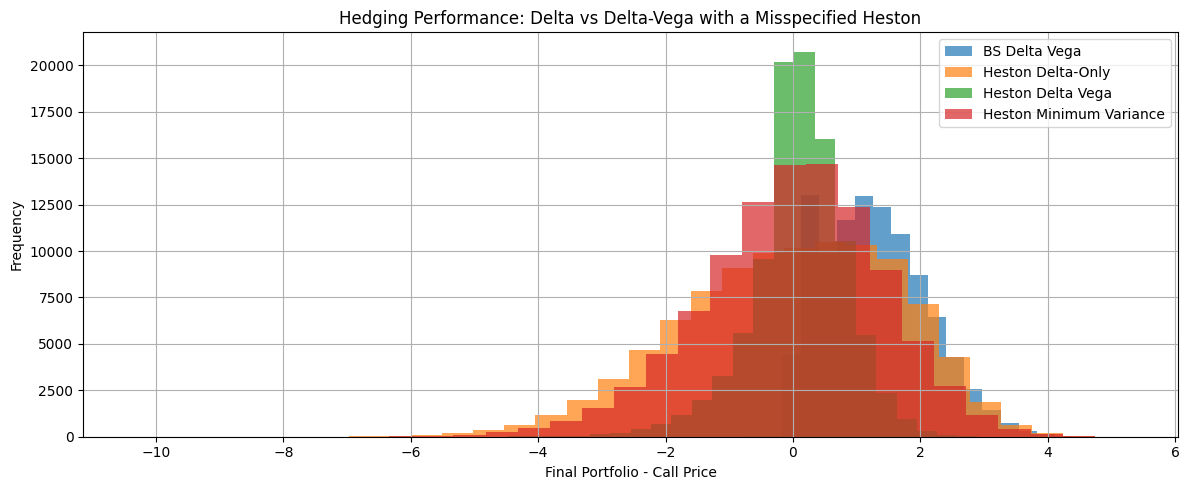

In [41]:

# Plot comparison
plt.figure(figsize=(12,5))
#plt.hist(bs_hedging_perf_delta_only, bins=30, alpha=0.7, label='BS Delta-Only')
plt.hist(bs_hedging_perf_delta_vega, bins=30, alpha=0.7, label='BS Delta Vega')
plt.hist(heston_hedging_perf_delta_only, bins=30, alpha=0.7, label='Heston Delta-Only')
plt.hist(heston_hedging_perf_delta_vega, bins=30, alpha=0.7, label='Heston Delta Vega')
plt.hist(hest_minvar, bins=30, alpha=0.7, label='Heston Minimum Variance')
plt.legend()
plt.title("Hedging Performance: Delta vs Delta-Vega with a Misspecified Heston")
plt.xlabel("Final Portfolio - Call Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

Average Heston minus BS initial price: -1.1099
Average BS IV Error Integral:    0.0000
Average heston IV Error Integral:    0.0000
Average BS Delta-Only P/L:        1.0833
Variance BS Delta-Only P/L:        2.8756
Average BS Delta-Vega-Hedge P/L:  1.1998
Variance BS Delta-Vega-Hedge P/L:  1.0073
Average Heston Delta-Only P/L: -0.0263
Variance Heston Delta-Only P/L: 3.6212
Average Heston Delta-Vega P/L: 0.0170
Variance Heston Delta-Vega P/L: 0.9209


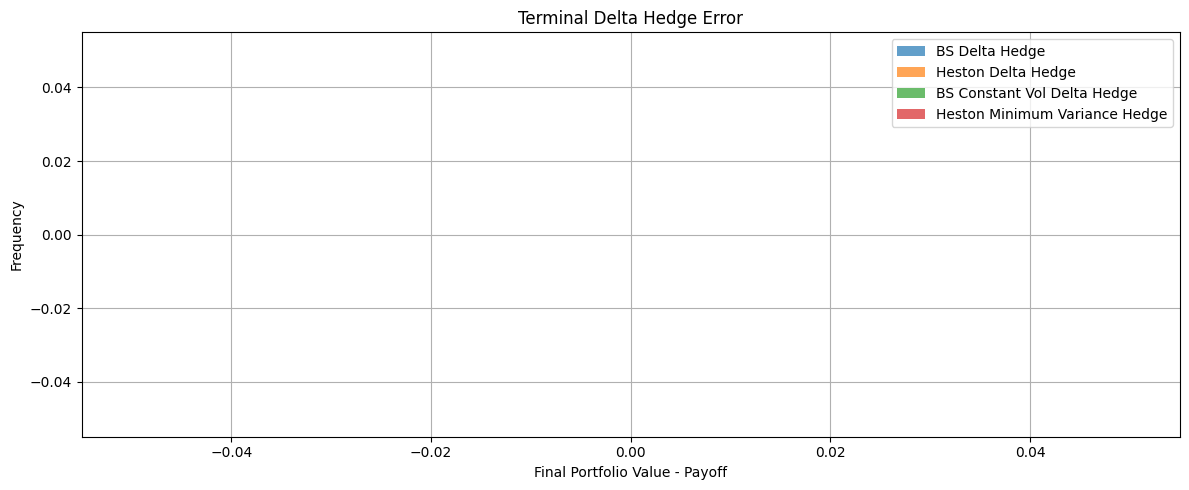

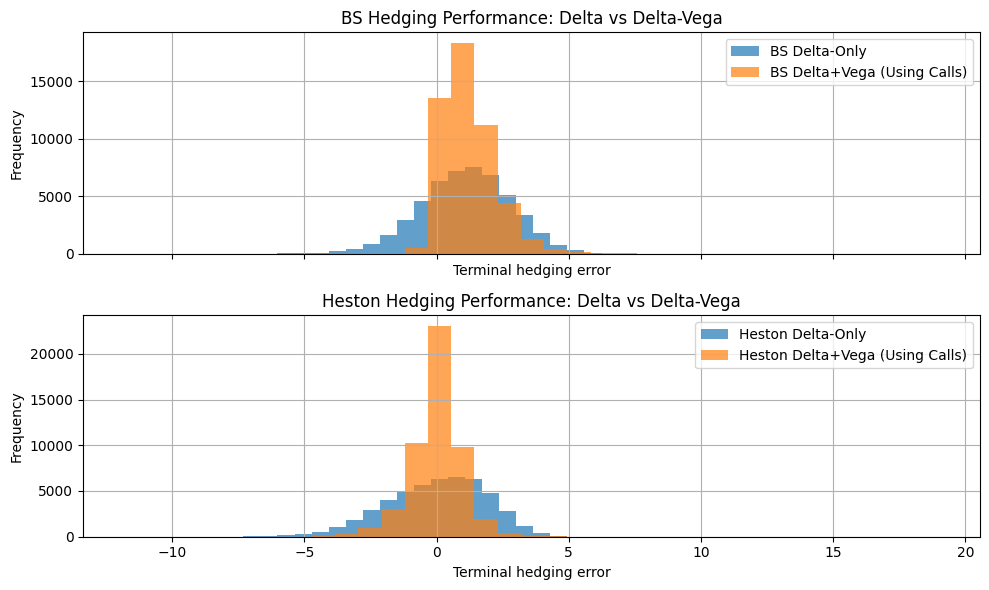

In [310]:
print(f"Average Heston minus BS initial price: {(heston_minus_bs_initial_price/sims):.4f}")

print(f"Average BS IV Error Integral:    {bs_iv_error_integrals.mean():.4f}")
print(f"Average heston IV Error Integral:    {heston_iv_error_integrals.mean():.4f}")
print(f"Average BS Delta-Only P/L:        {bs_hedging_perf_delta_only.mean():.4f}")
print(f"Variance BS Delta-Only P/L:        {bs_hedging_perf_delta_only.var():.4f}")
print(f"Average BS Delta-Vega-Hedge P/L:  {bs_hedging_perf_delta_vega.mean():.4f}")
print(f"Variance BS Delta-Vega-Hedge P/L:  {bs_hedging_perf_delta_vega.var():.4f}")
print(f"Average Heston Delta-Only P/L: {heston_hedging_perf_delta_only.mean():.4f}")
print(f"Variance Heston Delta-Only P/L: {heston_hedging_perf_delta_only.var():.4f}")
print(f"Average Heston Delta-Vega P/L: {heston_hedging_perf_delta_vega.mean():.4f}")
print(f"Variance Heston Delta-Vega P/L: {heston_hedging_perf_delta_vega.var():.4f}")

# 1) build a shared bin‐array for the two "delta only" series
delta_only_all = np.concatenate([
    bs_hedging_perf_delta_only,
    heston_hedging_perf_delta_only
])
bins_delta = np.linspace(
    delta_only_all.min(),
    delta_only_all.max(),
    31  # 31 edges → 30 bins
)

# 2) build a shared bin‐array for the two "delta+vega" series
delta_vega_all = np.concatenate([
    bs_hedging_perf_delta_vega,
    heston_hedging_perf_delta_vega
])
bins_vega = np.linspace(
    delta_vega_all.min(),
    delta_vega_all.max(),
    31
)

# 1) build a shared bin‐array for all four "delta‐only" series
delta_only_all = np.concatenate([
    bs_hedging_perf_delta_only,
    heston_hedging_perf_delta_only,
    bs_constvol_hedging_perf_delta_only,
    heston_hedging_perf_minvar_delta_only
])
bins_delta_all = np.linspace(
    delta_only_all.min(),
    delta_only_all.max(),
    31   # 31 edges → 30 equal‐width bins
)

# 2) plot all four histograms using that fixed bin array
plt.figure(figsize=(12,5))
plt.hist(bs_hedging_perf_delta_only,        bins=bins_delta_all, alpha=0.7, label='BS Delta Hedge')
plt.hist(heston_hedging_perf_delta_only,    bins=bins_delta_all, alpha=0.7, label='Heston Delta Hedge')
plt.hist(bs_constvol_hedging_perf_delta_only,       bins=bins_delta_all, alpha=0.7, label='BS Constant Vol Delta Hedge')
plt.hist(heston_hedging_perf_minvar_delta_only,     bins=bins_delta_all, alpha=0.7, label='Heston Minimum Variance Hedge')
plt.legend()
plt.title("Terminal Delta Hedge Error")
plt.xlabel("Final Portfolio Value - Payoff")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

# 3) plot, re-using the appropriate bins in each call
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# BS plot: delta-only uses bins_delta, delta+vega uses bins_vega
ax1.hist(bs_hedging_perf_delta_only, bins=bins_delta, alpha=0.7, label='BS Delta-Only')
ax1.hist(bs_hedging_perf_delta_vega,  bins=bins_vega,  alpha=0.7, label='BS Delta+Vega (Using Calls)')
ax1.set(
    xlabel='Terminal hedging error',
    ylabel='Frequency',
    title='BS Hedging Performance: Delta vs Delta-Vega'
)
ax1.legend()
ax1.grid(True)

# Heston plot: same bins arrays for the corresponding series
ax2.hist(heston_hedging_perf_delta_only, bins=bins_delta, alpha=0.7, label='Heston Delta-Only')
ax2.hist(heston_hedging_perf_delta_vega,  bins=bins_vega,  alpha=0.7, label='Heston Delta+Vega (Using Calls)')
ax2.set(
    xlabel='Terminal hedging error',
    ylabel='Frequency',
    title='Heston Hedging Performance: Delta vs Delta-Vega'
)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

Heston minus BS initial price: -0.0083


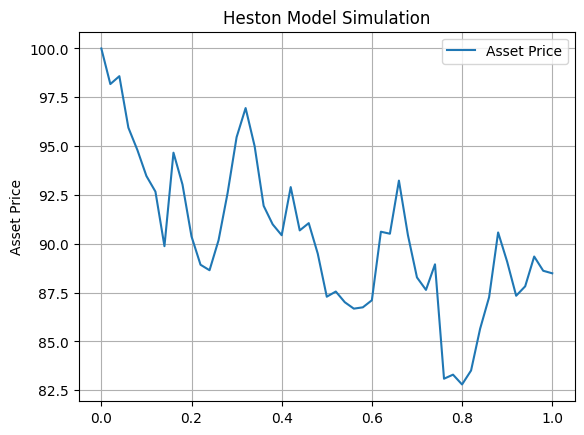

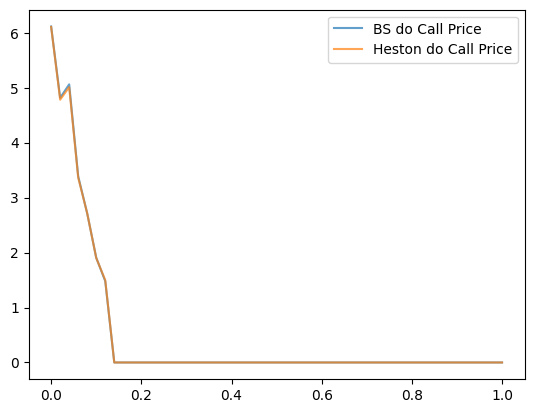

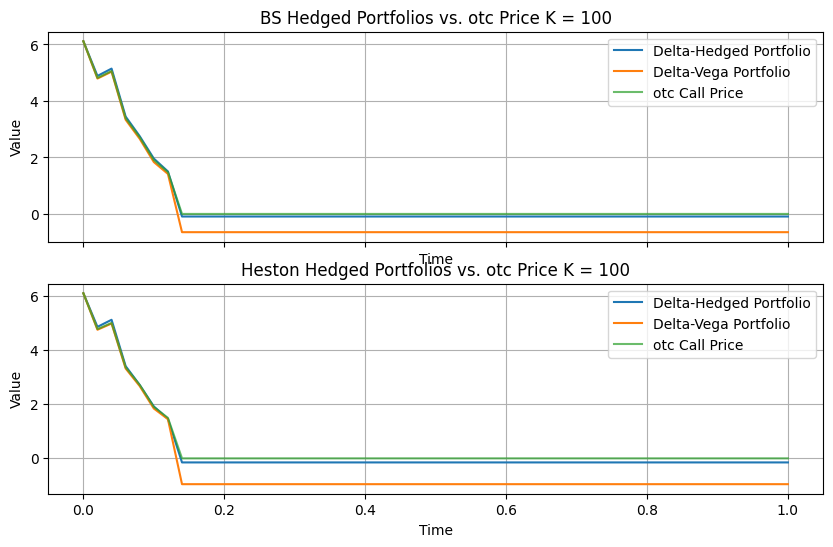

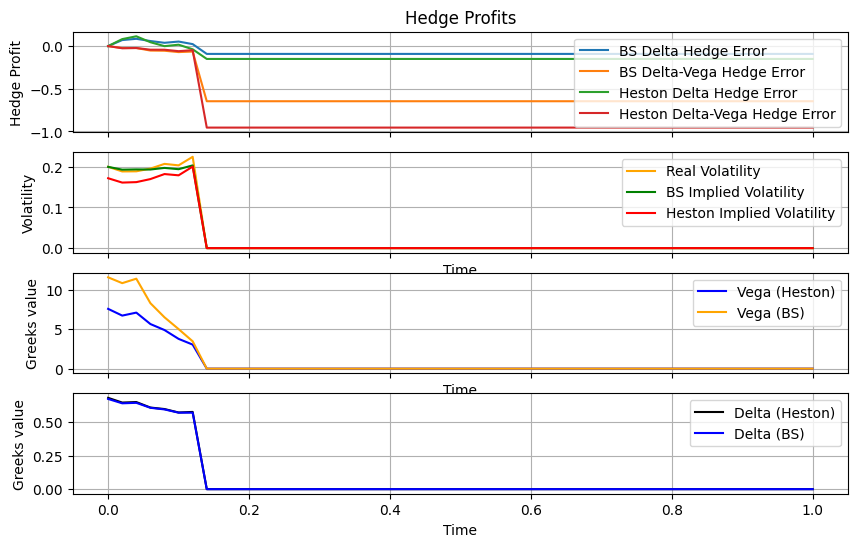

In [78]:
#OTC is a down-and-out barrier call - single graphical test



real_stein_stein = False
real_with_jumps = False

K_market = 95  # Market strike
K_otc  = 100  # otc strike
B_otc = 90  # Barrier strike

mc_sims = 100

# 1) Heston simulation
if real_with_jumps:
    t_grid, S_path, v_path = simulate_heston_jump(S0, v0, r, kappa, theta, xi, rho, muj, sigmaj, lam, T, steps)
elif real_stein_stein:
    t_grid, S_path, v_path = simulate_stein_stein(S0, sigma0_stein, r, kappa_stein, theta_stein, xi_stein, rho_stein, T, steps)
else:
    t_grid, S_path, v_path = simulate_heston(S0, v0, r, kappa, theta, xi, rho, T, steps)

n  = len(t_grid)
dt = t_grid[1] - t_grid[0]

# Preallocate
market_prices        = np.zeros(n)
market_bs_deltas     = np.zeros(n)
market_bs_vegas      = np.zeros(n)
market_heston_deltas = np.zeros(n)
market_heston_vegas  = np.zeros(n)
otc_bs_prices        = np.zeros(n)
otc_bs_deltas        = np.zeros(n)
otc_bs_vegas         = np.zeros(n)
otc_heston_prices    = np.zeros(n)
otc_heston_deltas    = np.zeros(n)
otc_heston_vegas     = np.zeros(n)
bs_implied_vols      = np.zeros(n)
heston_implied_vols  = np.zeros(n)

real_vols = np.sqrt(v_path)

est_error = 0.4
# Incorrect paramter estimation by uniform +- % error
kappa_est = kappa + kappa * np.random.uniform(-est_error, est_error)
theta_est = theta + theta * np.random.uniform(-est_error, est_error)
xi_est = xi + xi    * np.random.uniform(-est_error, est_error)
rho_est = rho + rho   * np.random.uniform(-est_error, est_error)

# Compute call prices, implied vols, barrier values & Greeks
for i, t in enumerate(t_grid):
    tau = T - t

    # Heston call price
    if real_with_jumps:
        market_prices[i] = heston_call_price(S_path[i], v_path[i], r, kappa, theta, xi, rho, muj, sigmaj, lam, tau, K_market)
    elif real_stein_stein:
        market_prices[i] = stein_stein_call_price(S_path[i], real_vols[i], r,theta_stein, kappa_stein, xi_stein, rho_stein, tau, K_market)
    else:
        market_prices[i] = heston_call_price(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)

    # Implied vols
    try:
        iv = bs_iv(market_prices[i], S_path[i], K_market, tau, r, 'c')
        bs_implied_vols[i] = iv if iv > 0 else bs_implied_vols[i-1]
    except:
        bs_implied_vols[i] = bs_implied_vols[i-1]
    
    try:
        heston_implied_vols[i] = (heston_implied_vol(S_path[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market, market_prices[i]))**2
    except:
        heston_implied_vols[i] = heston_implied_vols[i-1]

    if heston_implied_vols[i] < 1e-6:
        heston_implied_vols[i] = heston_implied_vols[i-1]

    # Barrier hit: zero out remaining
    if S_path[i] <= B_otc:  
        market_prices[i:]   = 0.0
        market_bs_deltas[i:] = 0.0
        market_bs_vegas[i:]  = 0.0
        market_heston_deltas[i:] = 0.0
        market_heston_vegas[i:]  = 0.0
        otc_bs_prices[i:]    = 0.0
        otc_bs_deltas[i:]     = 0.0
        otc_bs_vegas[i:]      = 0.0
        otc_heston_prices[i:] = 0.0
        otc_heston_deltas[i:] = 0.0
        otc_heston_vegas[i:]  = 0.0

        bs_implied_vols[i:]    = 0.0
        real_vols[i:]       = 0.0
        heston_implied_vols[i:] = 0.0
        break

    # Barrier pricing & Greeks
    otc_bs_prices[i]    = bs_price_do_call(S_path[i], K_otc, B_otc, tau, r, bs_implied_vols[i])
    otc_bs_deltas[i]     = bs_delta_do_call(S_path[i], K_otc, B_otc, tau, r, bs_implied_vols[i])
    otc_bs_vegas[i]      = bs_vega_do_call(S_path[i], K_otc, B_otc, tau, r, bs_implied_vols[i])
#    otc_heston_prices[i], otc_heston_deltas[i], otc_heston_vegas[i] = down_and_out_call_heston(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc),heston_barrier_delta_first_order(S_path[i], K_otc, B_otc, tau, r, heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est), heston_barrier_vega_first_order(S_path[i], K_otc, B_otc, tau, r, heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est)       

#    otc_heston_prices[i], otc_heston_deltas[i], otc_heston_vegas[i] = heston_mc_greeks_parallel(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc, n_paths=mc_sims)
    otc_heston_prices[i], otc_heston_deltas[i] = heston_down_out_call_price(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)
#    otc_heston_deltas[i] = heston_down_out_call_delta(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)
    otc_heston_vegas[i] = heston_down_out_call_vega(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)
#    otc_heston_prices[i], otc_heston_deltas[i], otc_heston_vegas[i] = heston_do_call_delta_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc, n_paths=mc_sims)
#    otc_heston_prices[i] = heston_do_call(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc, B_otc)
#    otc_heston_deltas[i] = heston_do_call_delta(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc, B_otc)
#    otc_heston_vegas[i]  = heston_do_call_vega(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc, B_otc)
    market_bs_deltas[i] = bs_call_delta(S_path[i], K_market, tau, r, bs_implied_vols[i])
    market_bs_vegas[i]  = bs_vega(S_path[i], K_market, tau, r, bs_implied_vols[i])
    market_heston_deltas[i] = heston_call_delta(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
    market_heston_vegas[i]  = heston_call_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)


# --- Delta-only hedge ---
portfolio_bs_delta = np.zeros(n)

# Simulate delta‐only P/L
cash = otc_bs_prices[0] - otc_bs_deltas[0] * S_path[0] # Sell option and buy stock
portfolio_bs_delta[0] = otc_bs_deltas[0] * S_path[0] + cash

for i in range(1, n):
    cash *= np.exp(r * dt)
    cash += (otc_bs_deltas[i-1] - otc_bs_deltas[i]) * S_path[i] # Sell previous amount in stock, buy new amount
    portfolio_bs_delta[i] = otc_bs_deltas[i] * S_path[i]  + cash

# --- Delta-only heston hedge ---
portfolio_heston_delta = np.zeros(n)

cash = otc_heston_prices[0] - otc_heston_deltas[0] * S_path[0] # Sell option and buy stock
portfolio_heston_delta[0] = otc_heston_deltas[0] * S_path[0] + cash
for i in range(1, n):
    cash *= np.exp(r * dt)
    cash += (otc_heston_deltas[i-1] - otc_heston_deltas[i]) * S_path[i]
    portfolio_heston_delta[i] = otc_heston_deltas[i] * S_path[i] + cash

# --- Delta‐Vega bs hedge with calls---
portfolio_bs_dv = np.zeros(n)

# Compute market (call) positions
market_positions = np.zeros(n)
for i in range(n):
    if market_bs_vegas[i] >= 1e-4:
        market_positions[i] = otc_bs_vegas[i] / market_bs_vegas[i]
    else:
        market_positions[i] = 0.0

# Compute the total delta you must hedge with the stock
delta_total = otc_bs_deltas - market_positions * market_bs_deltas

# Simulate delta‐vega P/L
cash = (otc_bs_prices[0] - delta_total[0] * S_path[0] - market_positions[0] * market_prices[0]) # Sell otc option and buy stock and market option
portfolio_bs_dv[0] = (delta_total[0] * S_path[0] + market_positions[0] * market_prices[0] + cash)

for i in range(1, n):
    cash *= np.exp(r * dt)
    cash += (delta_total[i-1] - delta_total[i]) * S_path[i] # Update stock position
    cash += (market_positions[i-1] - market_positions[i]) * market_prices[i] # Update market option position
    portfolio_bs_dv[i] = (delta_total[i] * S_path[i] + market_positions[i] * market_prices[i] + cash) 

# --- Delta‐Vega heston hedge with calls---
portfolio_heston_dv = np.zeros(n)

for i in range(n):
    if market_heston_vegas[i] >= 1e-4:
        market_positions[i] = otc_heston_vegas[i] / market_heston_vegas[i]
    else:
        market_positions[i] = 0.0

# Compute the total delta you must hedge with the stock
delta_total = otc_heston_deltas - market_positions * market_heston_deltas

cash = (otc_heston_prices[0] - delta_total[0] * S_path[0] - market_positions[0] * market_prices[0]) # Sell otc option and buy stock and market option
portfolio_heston_dv[0] = (delta_total[0] * S_path[0] + market_positions[0] * market_prices[0] + cash)

for i in range(1, n):
    cash *= np.exp(r * dt)
    cash += (delta_total[i-1] - delta_total[i]) * S_path[i]
    cash += (market_positions[i-1] - market_positions[i]) * market_prices[i]
    portfolio_heston_dv[i] = (delta_total[i] * S_path[i] + market_positions[i] * market_prices[i] + cash)

heston_implied_vols = np.sqrt(heston_implied_vols)

print(f"Heston minus BS initial price: {(otc_heston_prices[0] - otc_bs_prices[0]):.4f}")

plt.plot(t_grid, S_path, label='Asset Price')
plt.ylabel("Asset Price")
plt.title("Heston Model Simulation")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(t_grid, otc_bs_prices, label='BS do Call Price', alpha=0.7)
plt.plot(t_grid, otc_heston_prices, label='Heston do Call Price', alpha=0.7)
plt.legend()

# Plot delta vs delta-vega hedged portfolios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_grid, portfolio_bs_delta,   label='Delta-Hedged Portfolio')
ax1.plot(t_grid, portfolio_bs_dv, label='Delta-Vega Portfolio')
ax1.plot(t_grid, otc_bs_prices, label='otc Call Price', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title(f'BS Hedged Portfolios vs. otc Price K = {K_otc}')
ax1.legend()
ax1.grid(True)

ax2.plot(t_grid, portfolio_heston_delta, label='Delta-Hedged Portfolio')
ax2.plot(t_grid, portfolio_heston_dv, label='Delta-Vega Portfolio')
ax2.plot(t_grid, otc_heston_prices, label='otc Call Price', alpha=0.7)
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title(f'Heston Hedged Portfolios vs. otc Price K = {K_otc}')
ax2.legend()
ax2.grid(True)


fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 6), sharex=True)

ax1.plot(t_grid, portfolio_bs_delta - otc_bs_prices, label='BS Delta Hedge Error')
ax1.plot(t_grid, portfolio_bs_dv - otc_bs_prices, label='BS Delta-Vega Hedge Error')
ax1.plot(t_grid, portfolio_heston_delta - otc_heston_prices, label='Heston Delta Hedge Error')
ax1.plot(t_grid, portfolio_heston_dv - otc_heston_prices, label='Heston Delta-Vega Hedge Error')
ax2.set_xlabel("Time")
ax1.set_ylabel("Hedge Profit")
ax1.set_title("Hedge Profits")
ax1.legend()
ax1.grid(True)

ax2.plot(t_grid, real_vols, label='Real Volatility', color='orange')
ax2.plot(t_grid, bs_implied_vols, label='BS Implied Volatility', color='green')
ax2.plot(t_grid, heston_implied_vols, label='Heston Implied Volatility', color='red')
ax2.set_xlabel("Time")
ax2.set_ylabel("Volatility")
ax2.legend()
ax2.grid(True)

ax3.plot(t_grid, otc_heston_vegas, label='Vega (Heston)', color='blue')
ax3.plot(t_grid, otc_bs_vegas, label='Vega (BS)', color='orange')
ax3.set_xlabel("Time")
ax3.set_ylabel("Greeks value")
ax3.legend()
ax3.grid(True)

ax4.plot(t_grid, otc_heston_deltas, label='Delta (Heston)', color='black')
ax4.plot(t_grid, otc_bs_deltas, label='Delta (BS)', color='blue')
ax4.set_xlabel("Time")
ax4.set_ylabel("Greeks value")
ax4.legend()
ax4.grid(True)


Average IV Error Integral:    -0.0058
Average Delta-Only P/L:        -0.5171
Variance Delta-Only P/L:        1.8167
Average Delta-Vega-Hedge P/L:  -0.7678
Variance Delta-Vega-Hedge P/L:  0.9660
Average Heston Delta-Only P/L: -0.4844
Variance Heston Delta-Only P/L: 2.2085
Average Heston Delta-Vega P/L: -0.8445
Variance Heston Delta-Vega P/L: 0.8851


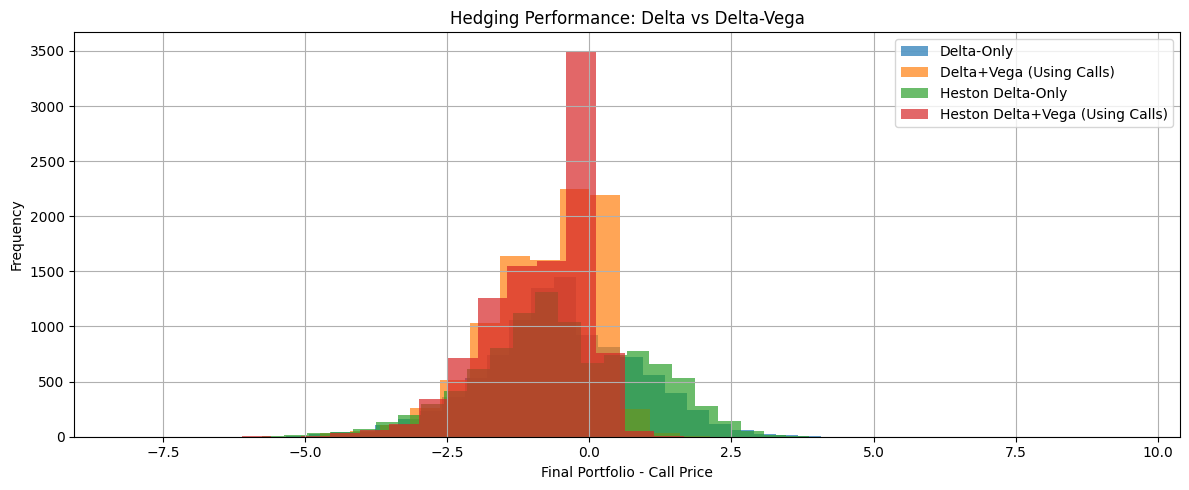

In [82]:
# OTC is a down-and-out barrier call, market is European call - terminal error test

# Number of simulations
sims = 10000

# mc_sims = 100

# Storage
bs_hedging_perf_delta_only = np.zeros(sims)
bs_hedging_perf_delta_vega = np.zeros(sims)
heston_hedging_perf_delta_only = np.zeros(sims)
heston_hedging_perf_delta_vega = np.zeros(sims)
# implied vol error integral
iv_error_integrals     = np.zeros(sims)

K_market = 95  # Market strike
K_otc  = 100  # otc strike
B_otc = 90  # Barrier strike


est_error = 0.4
# Incorrect paramter estimation by uniform +- % error
kappa_est = kappa + kappa * np.random.uniform(-est_error, est_error)
theta_est = theta + theta * np.random.uniform(-est_error, est_error)
xi_est = xi + xi    * np.random.uniform(-est_error, est_error)
rho_est = rho + rho   * np.random.uniform(-est_error, est_error)

for N in range(sims):
    # 1) Heston simulation
    t_grid, S_path, v_path = simulate_heston(S0, v0, r, kappa, theta, xi, rho, T, steps)
    n  = len(t_grid)
    dt = t_grid[1] - t_grid[0]

    # Preallocate
    market_prices        = np.zeros(n)
    market_bs_deltas     = np.zeros(n)
    market_bs_vegas      = np.zeros(n)
    market_heston_deltas = np.zeros(n)
    market_heston_vegas  = np.zeros(n)
    otc_bs_prices        = np.zeros(n)
    otc_bs_deltas        = np.zeros(n)
    otc_bs_vegas         = np.zeros(n)
    otc_heston_prices    = np.zeros(n)
    otc_heston_deltas    = np.zeros(n)
    otc_heston_vegas     = np.zeros(n)
    implied_vols         = np.zeros(n)

    # Compute call prices, implied vols, barrier values & Greeks
    for i, t in enumerate(t_grid):
        tau = T - t

        # Heston call price
        market_prices[i] = heston_call_price(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)

        # Implied vols
        try:
            iv = bs_iv(market_prices[i], S_path[i], K_market, tau, r, 'c')
            bs_implied_vols[i] = iv if iv > 0 else bs_implied_vols[i-1]
        except:
            bs_implied_vols[i] = bs_implied_vols[i-1]
        
        try:
            heston_implied_vols[i] = (heston_implied_vol(S_path[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market, market_prices[i]))**2
        except:
            heston_implied_vols[i] = heston_implied_vols[i-1]

        if heston_implied_vols[i] < 1e-6:
            heston_implied_vols[i] = heston_implied_vols[i-1]

        # Barrier hit: zero out remaining
        if S_path[i] <= B_otc:  
            market_prices[i:]   = 0.0
            market_bs_deltas[i:] = 0.0
            market_bs_vegas[i:]  = 0.0
            market_heston_deltas[i:] = 0.0
            market_heston_vegas[i:]  = 0.0
            otc_bs_prices[i:]    = 0.0
            otc_bs_deltas[i:]     = 0.0
            otc_bs_vegas[i:]      = 0.0
            otc_heston_prices[i:] = 0.0
            otc_heston_deltas[i:] = 0.0
            otc_heston_vegas[i:]  = 0.0

            implied_vols[i:]    = 0.0
            real_vols[i:]       = 0.0
            break

        # # Barrier pricing & Greeks
        # otc_bs_prices[i]    = bs_price_do_call(S_path[i], K_otc, B_otc, tau, r, implied_vols[i])
        # otc_bs_deltas[i]     = bs_delta_do_call(S_path[i], K_otc, B_otc, tau, r, implied_vols[i])
        # otc_bs_vegas[i]      = bs_vega_do_call(S_path[i], K_otc, B_otc, tau, r, implied_vols[i])
        # otc_heston_prices[i] = heston_down_out_call_price(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)
        # otc_heston_deltas[i] = heston_down_out_call_delta(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)
        # otc_heston_vegas[i] = heston_down_out_call_vega(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)       
        # market_bs_deltas[i] = bs_call_delta(S_path[i], K_market, tau, r, implied_vols[i])
        # market_bs_vegas[i]  = bs_vega(S_path[i], K_market, tau, r, implied_vols[i])
        # market_heston_deltas[i] = heston_call_delta(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)
        # market_heston_vegas[i]  = heston_call_vega(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_market)

        # Barrier pricing & Greeks
        otc_bs_prices[i]    = bs_price_do_call(S_path[i], K_otc, B_otc, tau, r, bs_implied_vols[i])
        otc_bs_deltas[i]     = bs_delta_do_call(S_path[i], K_otc, B_otc, tau, r, bs_implied_vols[i])
        otc_bs_vegas[i]      = bs_vega_do_call(S_path[i], K_otc, B_otc, tau, r, bs_implied_vols[i])
    #    otc_heston_prices[i], otc_heston_deltas[i], otc_heston_vegas[i] = down_and_out_call_heston(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc),heston_barrier_delta_first_order(S_path[i], K_otc, B_otc, tau, r, heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est), heston_barrier_vega_first_order(S_path[i], K_otc, B_otc, tau, r, heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est)       

    #    otc_heston_prices[i], otc_heston_deltas[i], otc_heston_vegas[i] = heston_mc_greeks_parallel(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc, n_paths=mc_sims)
        otc_heston_prices[i], otc_heston_deltas[i] = heston_down_out_call_price(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)
        otc_heston_vegas[i] = heston_down_out_call_vega(S_path[i], heston_implied_vols[i], kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc)

    #    otc_heston_prices[i], otc_heston_deltas[i], otc_heston_vegas[i] = heston_do_call_delta_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_otc, B_otc, n_paths=mc_sims)
    #    otc_heston_prices[i] = heston_do_call(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc, B_otc)
    #    otc_heston_deltas[i] = heston_do_call_delta(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc, B_otc)
    #    otc_heston_vegas[i]  = heston_do_call_vega(S_path[i], v_path[i], r, kappa, theta, xi, rho, tau, K_otc, B_otc)
        market_bs_deltas[i] = bs_call_delta(S_path[i], K_market, tau, r, bs_implied_vols[i])
        market_bs_vegas[i]  = bs_vega(S_path[i], K_market, tau, r, bs_implied_vols[i])
        market_heston_deltas[i] = heston_call_delta(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)
        market_heston_vegas[i]  = heston_call_vega(S_path[i], heston_implied_vols[i], r, kappa_est, theta_est, xi_est, rho_est, tau, K_market)

    #  IV-misfit integral
    iv_error_integrals[N] = np.trapezoid(implied_vols - real_vols, t_grid)

    # --- Delta-only hedge ---
    portfolio_bs_delta = np.zeros(n)

    # Simulate delta‐only P/L
    cash = otc_bs_prices[0] - otc_bs_deltas[0] * S_path[0] # Sell option and buy stock
    portfolio_bs_delta[0] = otc_bs_deltas[0] * S_path[0] + cash

    for i in range(1, n):
        cash *= np.exp(r * dt)
        cash += (otc_bs_deltas[i-1] - otc_bs_deltas[i]) * S_path[i] # Sell previous amount in stock, buy new amount
        portfolio_bs_delta[i] = otc_bs_deltas[i] * S_path[i]  + cash

    bs_hedging_perf_delta_only[N] = portfolio_bs_delta[-1] - otc_bs_prices[-1]

    # --- Delta-only heston hedge ---
    portfolio_heston_delta = np.zeros(n)

    cash = otc_heston_prices[0] - otc_heston_deltas[0] * S_path[0] # Sell option and buy stock
    portfolio_heston_delta[0] = otc_heston_deltas[0] * S_path[0] + cash
    for i in range(1, n):
        cash *= np.exp(r * dt)
        cash += (otc_heston_deltas[i-1] - otc_heston_deltas[i]) * S_path[i]
        portfolio_heston_delta[i] = otc_heston_deltas[i] * S_path[i] + cash

    heston_hedging_perf_delta_only[N] = portfolio_heston_delta[-1] - otc_heston_prices[-1]

    # --- Delta‐Vega bs hedge with calls---
    portfolio_bs_dv = np.zeros(n)

    # Compute market (call) positions
    market_positions = np.zeros(n)
    for i in range(n):
        if market_bs_vegas[i] >= 1e-4:
            market_positions[i] = otc_bs_vegas[i] / market_bs_vegas[i]
        else:
            market_positions[i] = 0.0

    # Compute the total delta you must hedge with the stock
    delta_total = otc_bs_deltas - market_positions * market_bs_deltas

    # Simulate delta‐vega P/L
    cash = (otc_bs_prices[0] - delta_total[0] * S_path[0] - market_positions[0] * market_prices[0]) # Sell otc option and buy stock and market option
    portfolio_bs_dv[0] = (delta_total[0] * S_path[0] + market_positions[0] * market_prices[0] + cash)

    for i in range(1, n):
        cash *= np.exp(r * dt)
        cash += (delta_total[i-1] - delta_total[i]) * S_path[i] # Update stock position
        cash += (market_positions[i-1] - market_positions[i]) * market_prices[i] # Update market option position
        portfolio_bs_dv[i] = (delta_total[i] * S_path[i] + market_positions[i] * market_prices[i] + cash) 
    bs_hedging_perf_delta_vega[N] = portfolio_bs_dv[-1] - otc_bs_prices[-1]

    # --- Delta‐Vega heston hedge with calls---
    portfolio_heston_dv = np.zeros(n)

    for i in range(n):
        if market_heston_vegas[i] >= 1e-4:
            market_positions[i] = otc_heston_vegas[i] / market_heston_vegas[i]
        else:
            market_positions[i] = 0.0
    
    # Compute the total delta you must hedge with the stock
    delta_total = otc_heston_deltas - market_positions * market_heston_deltas

    cash = (otc_heston_prices[0] - delta_total[0] * S_path[0] - market_positions[0] * market_prices[0]) # Sell otc option and buy stock and market option
    portfolio_heston_dv[0] = (delta_total[0] * S_path[0] + market_positions[0] * market_prices[0] + cash)

    for i in range(1, n):
        cash *= np.exp(r * dt)
        cash += (delta_total[i-1] - delta_total[i]) * S_path[i]
        cash += (market_positions[i-1] - market_positions[i]) * market_prices[i]
        portfolio_heston_dv[i] = (delta_total[i] * S_path[i] + market_positions[i] * market_prices[i] + cash)
    heston_hedging_perf_delta_vega[N] = portfolio_heston_dv[-1] - otc_heston_prices[-1]

# --- Results ---
print(f"Average IV Error Integral:    {iv_error_integrals.mean():.4f}")
print(f"Average Delta-Only P/L:        {bs_hedging_perf_delta_only.mean():.4f}")
print(f"Variance Delta-Only P/L:        {bs_hedging_perf_delta_only.var():.4f}")
print(f"Average Delta-Vega-Hedge P/L:  {bs_hedging_perf_delta_vega.mean():.4f}")
print(f"Variance Delta-Vega-Hedge P/L:  {bs_hedging_perf_delta_vega.var():.4f}")
print(f"Average Heston Delta-Only P/L: {heston_hedging_perf_delta_only.mean():.4f}")
print(f"Variance Heston Delta-Only P/L: {heston_hedging_perf_delta_only.var():.4f}")
print(f"Average Heston Delta-Vega P/L: {heston_hedging_perf_delta_vega.mean():.4f}")
print(f"Variance Heston Delta-Vega P/L: {heston_hedging_perf_delta_vega.var():.4f}")

# Plot comparison
plt.figure(figsize=(12,5))
plt.hist(bs_hedging_perf_delta_only, bins=30, alpha=0.7, label='Delta-Only')
plt.hist(bs_hedging_perf_delta_vega, bins=30, alpha=0.7, label='Delta+Vega (Using Calls)')
plt.hist(heston_hedging_perf_delta_only, bins=30, alpha=0.7, label='Heston Delta-Only')
plt.hist(heston_hedging_perf_delta_vega, bins=30, alpha=0.7, label='Heston Delta+Vega (Using Calls)')
plt.legend()
plt.title("Hedging Performance: Delta vs Delta-Vega")
plt.xlabel("Final Portfolio - Call Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()


In [83]:
print(bootstrap_variance_ci(bs_hedging_perf_delta_only))
print(bootstrap_variance_ci(heston_hedging_perf_delta_only))
print(bootstrap_variance_ci(bs_hedging_perf_delta_vega))
print(bootstrap_variance_ci(heston_hedging_perf_delta_vega))



(np.float64(1.7605303985211083), np.float64(1.873322519251904))
(np.float64(2.1459940922987997), np.float64(2.2717952798674346))
(np.float64(0.9301813527032952), np.float64(1.0049663369104942))
(np.float64(0.8463427794246587), np.float64(0.9288887113268551))


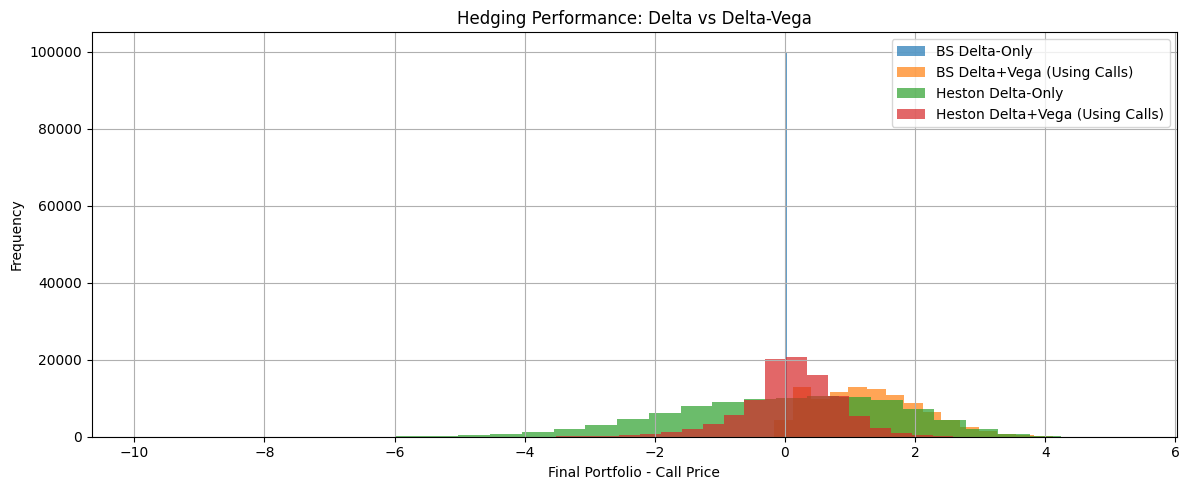

In [42]:
# Plot comparison
plt.figure(figsize=(12,5))
plt.hist(bs_hedging_perf_delta_only, bins=30, alpha=0.7, label='BS Delta-Only')
plt.hist(bs_hedging_perf_delta_vega, bins=30, alpha=0.7, label='BS Delta+Vega (Using Calls)')
plt.hist(heston_hedging_perf_delta_only, bins=30, alpha=0.7, label='Heston Delta-Only')
plt.hist(heston_hedging_perf_delta_vega, bins=30, alpha=0.7, label='Heston Delta+Vega (Using Calls)')
plt.legend()
plt.title("Hedging Performance: Delta vs Delta-Vega")
plt.xlabel("Final Portfolio - Call Price")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()